# Ranking simulations based on quality evaluation based on order parameters

This notebook:

1. Ranks the individual simulations based on quality of order parameters of different fragments (headgroup, acyl chains and all order parameters)
2. Ranks simulations based on quality of invidual lipids

These rankings help to find the best simulations or force fields to analyze certain types of membranes or certain lipids.

# Initialize NMRlipids databank

In [19]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
#import mdtraj
import urllib.request
import yaml
import pprint
import pandas as pd
from pandas.io.json import json_normalize
import math
import numpy as np

sys.path.insert(1, '../BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def ShowTable(SortedQualities, quality):
    rounding = ['headgroup', 'sn-1', 'sn-2', 'total']
    QualityTable = []
    pd.set_option('display.max_rows', None)
    for i in SortedQualities:
        StoredToTable = []
        #
        #
        for k, v in i[quality].items():
            #print(k,v)
            if k in rounding:
                if v != float("inf") and not math.isnan(v):
                    i[quality][k] = round(float(v), 2)
        #
        #
        StoredToTable = i[quality]
        StoredToTable['Forcefield'] = i['system']['FF']
        molecules = ''
        MolNumbers = ''
        for lipid in i['system']['COMPOSITION']:
            #print(np.sum(i['system']['COMPOSITION'][lipid]['COUNT']))
            molecules = molecules + lipid + ':'
            MolNumbers = MolNumbers + str(np.sum(i['system']['COMPOSITION'][lipid]['COUNT']))  + ':'
        StoredToTable['Molecules'] = molecules[:-1]
        StoredToTable['Number of molecules'] = ' (' + MolNumbers[:-1] + ')'
        StoredToTable['Temperature'] = i['system']['TEMPERATURE']
        StoredToTable['DOI'] = i['system']['DOI']
        QualityTable.append(StoredToTable)    
    display(pd.json_normalize(QualityTable))

# Making a list of qualities

In [2]:
qualities = []
for system in systems:
    quality_dict = {}
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    
    TotalQualityFilePath = path + '/SYSTEM_quality.json'
    
    FragmentQ = {}
    for lipid in readme['COMPOSITION']:
        QualityFile = path + lipid + '_FragmentQuality.json'
        #print(QualityFile)
        try:
            with open(QualityFile) as json_file:
                FragmentQ[lipid] = json.load(json_file)
            json_file.close()
        except:
            continue
        #print(lipid, FragmentQ[lipid])
    
    if (os.path.isfile(TotalQualityFilePath)):
        with open(TotalQualityFilePath) as json_file:
            FragmentQ['TotalQuality'] = json.load(json_file)
        json_file.close()
        #print(FragmentQ['TotalQuality'], '\n')

    FFQualityFilePath = path + '/FormFactorQuality.json'
    if (os.path.isfile(FFQualityFilePath)):
        with open(FFQualityFilePath) as json_file:
            FFq = json.load(json_file)
        try:
            FragmentQ['TotalQuality']
        except:
            FragmentQ['TotalQuality'] = {}
        #print(FragmentQ['TotalQuality']['headgroup'], FFq)
        try:
            FragmentQ['TotalQuality']['FFQuality'] = FFq[0]
        except:
            FragmentQ['TotalQuality']['FFQuality'] = FFq    
        json_file.close()
        #print(FragmentQ['TotalQuality'], '\n')
    
    FragmentQ['system'] = system
    qualities.append(FragmentQ)

# Sort based on total quality of a simulation

In [3]:
Fragments = ['total','sn-1','sn-2','headgroup']

for SortBasedOn in Fragments:
    #print(SortBasedOn)
    NewQualities = []
    for i in qualities:
        try:
            if i['TotalQuality'][SortBasedOn] >0:
                NewQualities.append(i)
            #totalQ = i['TotalQuality']['headgroup']
        except:
            continue

    
    SortedQualities = sorted(NewQualities, key = lambda i: i['TotalQuality'][SortBasedOn], reverse = True)
    print('Sorted based on ', SortBasedOn, ' quality')
    ShowTable(SortedQualities,'TotalQuality')
    
    outputfile = '../../Data/Ranking/SYSTEM_' + SortBasedOn + '_Ranking.json'
    with open(outputfile, "w") as fp:
        json.dump(SortedQualities, fp)
        

NewQualities = []
for i in qualities:
    try:
        if i['TotalQuality']['FFQuality'] >0:
            NewQualities.append(i)
            #totalQ = i['TotalQuality']['headgroup']
    except:
        continue

        
SortedQualities = sorted(NewQualities, key = lambda i: i['TotalQuality']['FFQuality'])
print('Sorted based on form factor quality')
ShowTable(SortedQualities,'TotalQuality')
    
outputfile = '../../Data/Ranking/SYSTEM_FormFactor_Ranking.json'
with open(outputfile, "w") as fp:
    json.dump(SortedQualities, fp)
    

Sorted based on  total  quality


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.61,0.84,0.82,0.76,514.766945,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
1,0.63,0.70,0.76,0.69,713.024817,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
2,0.64,0.48,0.72,0.61,674.021485,MacRog,POPC:SOL,(288:14400),298.00,10.5281/zenodo.13498
3,0.65,0.74,0.42,0.60,576.169287,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.3335503
4,0.01,0.88,0.84,0.58,,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
5,0.02,0.83,0.78,0.55,,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
6,0.65,0.54,0.43,0.54,613.125521,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.1118980
7,0.01,0.79,0.77,0.52,122.168365,Slipids,POPE:SOL,(500:25000),310.00,10.5281/zenodo.3231342
8,0.10,0.87,0.57,0.51,140.087165,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
9,0.10,0.86,0.57,0.51,136.680061,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813


Sorted based on  sn-1  quality


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.88,0.84,0.58,,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
1,0.10,0.87,0.57,0.51,140.087165,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
2,0.10,0.86,0.57,0.51,136.680061,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
3,0.61,0.84,0.82,0.76,514.766945,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
4,0.02,0.83,0.78,0.55,,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
5,0.01,0.79,0.77,0.52,122.168365,Slipids,POPE:SOL,(500:25000),310.00,10.5281/zenodo.3231342
6,0.65,0.74,0.42,0.60,576.169287,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.3335503
7,0.63,0.70,0.76,0.69,713.024817,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
8,0.16,0.64,0.69,0.50,297.214229,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.00,10.5281/zenodo.1488094
9,0.21,0.63,0.47,0.44,,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129431


Sorted based on  sn-2  quality


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.88,0.84,0.58,,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
1,0.61,0.84,0.82,0.76,514.766945,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,0.02,0.83,0.78,0.55,,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
3,0.01,0.79,0.77,0.52,122.168365,Slipids,POPE:SOL,(500:25000),310.00,10.5281/zenodo.3231342
4,0.63,0.70,0.76,0.69,713.024817,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
5,0.64,0.48,0.72,0.61,674.021485,MacRog,POPC:SOL,(288:14400),298.00,10.5281/zenodo.13498
6,0.16,0.64,0.69,0.50,297.214229,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.00,10.5281/zenodo.1488094
7,0.10,0.86,0.57,0.51,136.680061,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
8,0.10,0.87,0.57,0.51,140.087165,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
9,0.15,0.56,0.53,0.41,,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.00,10.5281/zenodo.1129435


Sorted based on  headgroup  quality


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.67,0.36,0.40,0.48,689.623863,CHARMM36,POPC:SOL,(256:9767),300.00,10.5281/zenodo.1306800
1,0.67,0.37,0.38,0.47,902.726741,CHARMM36,POPC:SOL,(1024:51200),298.15,10.5281/zenodo.5767451
2,0.66,0.33,0.36,0.45,705.475159,CHARMM36,POPC:SOL,(256:12800),298.15,10.5281/zenodo.5767451
3,0.65,0.54,0.43,0.54,613.125521,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.1118980
4,0.65,0.74,0.42,0.60,576.169287,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.3335503
5,0.64,0.48,0.72,0.61,674.021485,MacRog,POPC:SOL,(288:14400),298.00,10.5281/zenodo.13498
6,0.63,0.70,0.76,0.69,713.024817,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
7,0.62,0.39,0.29,0.43,553.99905,Lipid14 with Verlet scheme,POPC:SOL,(128:5120),298.15,10.5281/zenodo.30898
8,0.61,0.84,0.82,0.76,514.766945,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
9,0.58,0.32,0.36,0.42,758.458331,CHARMM36,POPC:SOL,(64:3200),298.15,10.5281/zenodo.5767451


Sorted based on form factor quality


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.79,0.77,0.52,122.168365,Slipids,POPE:SOL,(500:25000),310.00,10.5281/zenodo.3231342
1,0.10,0.86,0.57,0.51,136.680061,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
2,0.10,0.87,0.57,0.51,140.087165,Slipids,POPE:SOL,(336:13460),310.00,10.5281/zenodo.1293813
3,NaN,NaN,NaN,NaN,174.289315,Slipids,DPPC:SOL,(128:3840),323.00,10.5281/zenodo.13287
4,NaN,NaN,NaN,NaN,184.302177,CHARMM36,POPC:SOL,(128:5120),303.00,10.5281/zenodo.164206
5,NaN,NaN,NaN,NaN,189.156160,CHARMM36,POPC:SOL,(128:5120),303.00,10.5281/zenodo.164206
6,NaN,NaN,NaN,NaN,190.644832,CHARMM36,POPC:SOL,(128:4040),303.00,10.5281/zenodo.164203
7,NaN,NaN,NaN,NaN,190.698822,CHARMM36,POPC:SOL,(128:5120),303.00,10.5281/zenodo.164206
8,NaN,NaN,NaN,NaN,192.441871,CHARMM36,POPC:SOL,(128:5120),303.00,10.5281/zenodo.164206
9,NaN,NaN,NaN,NaN,193.061737,CHARMM36,POPC:SOL,(128:4040),303.00,10.5281/zenodo.164203


# Sorting best simulations for each lipid

In [13]:
SortedQualities

[{'POPC': {'headgroup': 0.75,
   'sn-1': 0.72,
   'sn-2': 0.76,
   'total': 0.75,
   'Forcefield': 'CHARMM36',
   'Molecules': 'POPC:CHOL:SOL',
   'Number of molecules': ' (1024:128:57600)',
   'Temperature': 298.15,
   'DOI': '10.5281/zenodo.5767451'},
  'TotalQuality': {'FFQuality': 893.5193738843263,
   'Forcefield': 'CHARMM36',
   'Molecules': 'POPC:CHOL:SOL',
   'Number of molecules': ' (1024:128:57600)',
   'Temperature': 298.15,
   'DOI': '10.5281/zenodo.5767451'},
  'system': {'DOI': '10.5281/zenodo.5767451',
   'SOFTWARE': 'gromacs',
   'TRJ': [['CHOL4_large.xtc']],
   'TPR': [['CHOL4_large.tpr']],
   'PREEQTIME': 0,
   'TIMELEFTOUT': 200,
   'COMPOSITION': {'POPC': {'NAME': 'POPC',
     'MAPPING': 'mappingPOPCcharmm.txt',
     'COUNT': [512, 512]},
    'CHOL': {'NAME': 'CHL1',
     'MAPPING': 'mappingCHOLESTEROLcharmm.txt',
     'COUNT': [63, 65]},
    'SOL': {'NAME': 'TIP3',
     'MAPPING': 'mappingTIP3PCHARMMgui.txt',
     'COUNT': 57600}},
   'DIR_WRK': '/home/lara/Databan

In [14]:
Fragments = ['total','sn-1','sn-2','headgroup']
#SortBasedOn = 'headgroup'

for SortBasedOn in Fragments:
    for lipid in lipids_dict:
        NewQualities = []
        for i in qualities:
            try:
                if i[lipid][SortBasedOn] >0:
                    NewQualities.append(i)
                #totalQ = i['TotalQuality']['headgroup']
            except:
                continue

    
        SortedQualities = sorted(NewQualities, key = lambda i: i[lipid][SortBasedOn], reverse = True)
        if SortedQualities:
            print('Quality of',SortBasedOn,' of ',lipid) #,'in simulation: ',  simulation[lipid][SortBasedOn])
            ShowTable(SortedQualities, lipid)
    
        if SortedQualities:
            outputfile = '../../Data/Ranking/' + lipid + '_' + SortBasedOn + '_Ranking.json'
            with open(outputfile, "w") as fp:
                json.dump(SortedQualities, fp)

    
        #for simulation in SortedQualities:
        #    for molecule in simulation['system']['COMPOSITION']:
        #        print(molecule, np.sum(simulation['system']['COMPOSITION'][molecule]['COUNT']))
        #    print(simulation['system']['FF'])
        #    print('Quality of',SortBasedOn,' of ',lipid,'in simulation: ',  simulation[lipid][SortBasedOn])
        #    print(simulation['system']['path'])
        #    print('\n')

Quality of total  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.61,0.84,0.82,0.76,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
1,0.75,0.72,0.76,0.75,CHARMM36,POPC:CHOL:SOL,(1024:128:57600),298.15,10.5281/zenodo.5767451
2,0.66,0.71,0.75,0.71,CHARMM36,POPC:CHOL:SOL,(64:8:3600),298.15,10.5281/zenodo.5767451
3,0.73,0.60,0.73,0.69,CHARMM36,POPC:CHOL:SOL,(256:32:14400),298.15,10.5281/zenodo.5767451
4,0.63,0.70,0.76,0.69,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
5,0.64,0.48,0.72,0.61,MacRog,POPC:SOL,(288:14400),298.00,10.5281/zenodo.13498
6,0.71,0.60,0.49,0.60,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434
7,0.65,0.74,0.42,0.60,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.3335503
8,0.01,0.88,0.84,0.58,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
9,0.69,0.48,0.52,0.57,Slipids,CHOL:POPC:SOL,(154:358:21183),298.00,10.5281/zenodo.62026


Quality of total  of  POPG


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.12,0.1,0.48,0.23,Slipids,POPG:SOL:SOD,(288:10664:288),298.0,10.5281/zenodo.546133


Quality of total  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.16,0.64,0.69,0.50,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1488094
1,0.21,0.63,0.47,0.44,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
2,0.15,0.56,0.53,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
3,0.13,0.61,0.49,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
4,0.20,0.35,0.43,0.33,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
5,0.11,0.16,0.26,0.18,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
6,0.14,0.03,0.34,0.17,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
7,0.14,0.10,0.24,0.16,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
8,0.26,0.06,0.08,0.13,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
9,0.19,0.07,0.08,0.11,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335


Quality of total  of  POPE


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.79,0.77,0.52,Slipids,POPE:SOL,(500:25000),310.0,10.5281/zenodo.3231342
1,0.10,0.87,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
2,0.10,0.86,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
3,0.54,0.52,0.27,0.44,CHARMM36,SOL:POPE,(5760:144),310.0,10.5281/zenodo.2641987
4,0.53,0.14,0.07,0.25,CHARMM36,SOL:POPE,(25000:500),310.0,10.5281/zenodo.3237461
5,0.09,0.12,0.35,0.19,Lipid17,POPE:SOL,(500:25000),310.0,10.5281/zenodo.4424292


Quality of total  of  CHOL


,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.24,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434
1,0.20,CHARMM36,POPC:CHOL:SOL,(64:56:6000),298.15,10.5281/zenodo.5767451
2,0.20,CHARMM36,POPC:CHOL:SOL,(256:224:24000),298.15,10.5281/zenodo.5767451
3,0.20,CHARMM36,POPC:CHOL:SOL,(1024:896:96000),298.15,10.5281/zenodo.5767451
4,0.17,Berger and Modified Höltje model for cholesterol,POPC:CHOL:SOL,(64:64:10314),298.00,10.5281/zenodo.4643862


Quality of sn-1  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.88,0.84,0.58,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
1,0.61,0.84,0.82,0.76,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,0.02,0.83,0.78,0.55,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
3,0.03,0.82,0.50,0.45,Berger and Modified Höltje model for cholesterol,POPC:CHOL:SOL,(120:8:7290),298.00,10.5281/zenodo.4643899
4,0.65,0.74,0.42,0.60,ECC-lipids,POPC:SOL,(128:6400),300.00,10.5281/zenodo.3335503
5,0.75,0.72,0.76,0.75,CHARMM36,POPC:CHOL:SOL,(1024:128:57600),298.15,10.5281/zenodo.5767451
6,0.66,0.71,0.75,0.71,CHARMM36,POPC:CHOL:SOL,(64:8:3600),298.15,10.5281/zenodo.5767451
7,0.63,0.70,0.76,0.69,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
8,0.71,0.60,0.49,0.60,slipids,CHOL:POPC:SOL,(256:256:20334),298.00,10.5281/zenodo.159434
9,0.73,0.60,0.73,0.69,CHARMM36,POPC:CHOL:SOL,(256:32:14400),298.15,10.5281/zenodo.5767451


Quality of sn-1  of  POPG


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.12,0.1,0.48,0.23,Slipids,POPG:SOL:SOD,(288:10664:288),298.0,10.5281/zenodo.546133


Quality of sn-1  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.16,0.64,0.69,0.50,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1488094
1,0.21,0.63,0.47,0.44,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
2,0.13,0.61,0.49,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
3,0.15,0.56,0.53,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
4,0.20,0.35,0.43,0.33,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
5,0.11,0.16,0.26,0.18,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
6,0.14,0.10,0.24,0.16,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
7,0.17,0.08,0.06,0.10,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335
8,0.19,0.07,0.08,0.11,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335
9,0.26,0.06,0.08,0.13,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415


Quality of sn-1  of  POPE


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.10,0.87,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
1,0.10,0.86,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
2,0.01,0.79,0.77,0.52,Slipids,POPE:SOL,(500:25000),310.0,10.5281/zenodo.3231342
3,0.54,0.52,0.27,0.44,CHARMM36,SOL:POPE,(5760:144),310.0,10.5281/zenodo.2641987
4,0.53,0.14,0.07,0.25,CHARMM36,SOL:POPE,(25000:500),310.0,10.5281/zenodo.3237461
5,0.09,0.12,0.35,0.19,Lipid17,POPE:SOL,(500:25000),310.0,10.5281/zenodo.4424292


Quality of sn-2  of  POPC


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.88,0.84,0.58,Berger,POPC:SOL,(256:10342),300.00,10.5281/zenodo.1402417
1,0.61,0.84,0.82,0.76,Slipids,POPC:SOL,(512:23943),298.00,10.5281/zenodo.166034
2,0.02,0.83,0.78,0.55,Berger,POPC:SOL,(128:7290),298.00,10.5281/zenodo.4643875
3,0.75,0.72,0.76,0.75,CHARMM36,POPC:CHOL:SOL,(1024:128:57600),298.15,10.5281/zenodo.5767451
4,0.63,0.70,0.76,0.69,MacRog,POPC:SOL,(128:5120),300.00,10.5281/zenodo.3741793
5,0.66,0.71,0.75,0.71,CHARMM36,POPC:CHOL:SOL,(64:8:3600),298.15,10.5281/zenodo.5767451
6,0.73,0.60,0.73,0.69,CHARMM36,POPC:CHOL:SOL,(256:32:14400),298.15,10.5281/zenodo.5767451
7,0.64,0.48,0.72,0.61,MacRog,POPC:SOL,(288:14400),298.00,10.5281/zenodo.13498
8,0.03,0.37,0.71,0.37,Berger and Modified Höltje model for cholesterol,POPC:CHOL:SOL,(110:18:8481),298.00,10.5281/zenodo.4643914
9,0.69,0.48,0.52,0.57,Slipids,CHOL:POPC:SOL,(154:358:21183),298.00,10.5281/zenodo.62026


Quality of sn-2  of  POPG


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.12,0.1,0.48,0.23,Slipids,POPG:SOL:SOD,(288:10664:288),298.0,10.5281/zenodo.546133


Quality of sn-2  of  POPS


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.16,0.64,0.69,0.50,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1488094
1,0.15,0.56,0.53,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
2,0.13,0.61,0.49,0.41,"GROMOS-CKP, GROMOS NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129435
3,0.21,0.63,0.47,0.44,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
4,0.20,0.35,0.43,0.33,"GROMOS-CKP, Berger/Chiu NH3 charges and PME",POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129431
5,0.14,0.03,0.34,0.17,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
6,0.11,0.16,0.26,0.18,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
7,0.14,0.10,0.24,0.16,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
8,0.26,0.06,0.08,0.13,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
9,0.19,0.07,0.08,0.11,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335


Quality of sn-2  of  POPE


,headgroup,sn-1,sn-2,total,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.01,0.79,0.77,0.52,Slipids,POPE:SOL,(500:25000),310.0,10.5281/zenodo.3231342
1,0.10,0.87,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
2,0.10,0.86,0.57,0.51,Slipids,POPE:SOL,(336:13460),310.0,10.5281/zenodo.1293813
3,0.09,0.12,0.35,0.19,Lipid17,POPE:SOL,(500:25000),310.0,10.5281/zenodo.4424292
4,0.54,0.52,0.27,0.44,CHARMM36,SOL:POPE,(5760:144),310.0,10.5281/zenodo.2641987
5,0.53,0.14,0.07,0.25,CHARMM36,SOL:POPE,(25000:500),310.0,10.5281/zenodo.3237461


Quality of headgroup  of  POPC


TypeError: must be real number, not str

# Show form factor ranking only for systems with a specific lipid

In [44]:
FFrankingPath = '../../Data/Ranking/SYSTEM_FormFactor_Ranking.json'
lipid = 'POPS'

with open(FFrankingPath) as json_file:
    FFranking = json.load(json_file)
json_file.close()

NewRank = []

for i in FFranking:
    #print(i)
    #for tst in i:
    #    print(tst)
    if lipid in i['TotalQuality']['Molecules']:
        NewRank.append(i)
   
ShowTable(NewRank,'TotalQuality')
    
FFrankingPath = '../../Data/Ranking/POPC_sn-1_Ranking.json'
with open(FFrankingPath) as json_file:
    FFranking = json.load(json_file)
json_file.close()

NewRank = []

for i in FFranking:
    #print(i)
    #for tst in i:
    #    print(tst)
    if lipid in i['POPC']['Molecules']:
        NewRank.append(i)
   
ShowTable(NewRank,'POPC')


,headgroup,sn-1,sn-2,total,FFQuality,Forcefield,Molecules,Number of molecules,Temperature,DOI
0,0.11,0.16,0.26,0.18,239.292791,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
1,0.16,0.64,0.69,0.50,297.214229,"ECC-lipids, SPC water model, ECC-ions",POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1488094
2,0.14,0.10,0.24,0.16,328.887960,Slipids,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129441
3,0.14,0.03,0.34,0.17,669.946454,Lipid17 and ff99 ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487906
4,0.26,0.06,0.08,0.13,1259.961799,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
5,0.17,0.08,0.06,0.10,1376.208930,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335
6,0.19,0.07,0.08,0.11,1563.963308,MacRog,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1283335
7,0.18,0.01,0.06,0.08,1696.494223,CHARMM36,POPS:SOL:SOD,(128:4480:128),298.0,10.5281/zenodo.1129415
8,0.08,0.01,0.04,0.04,1922.434454,Lipid17 and Dang ions,POPS:SOL:SOD,(72:3600:72),298.0,10.5281/zenodo.1487761


""


# Making very rough plots on quality

This is not very user friendly. Can be probably removed once the GUI works.

/tmp/ipykernel_4960/208112679.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  plt.plot(5,value[5],"s",color='red',label = l,marker=".", markersize=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels f

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

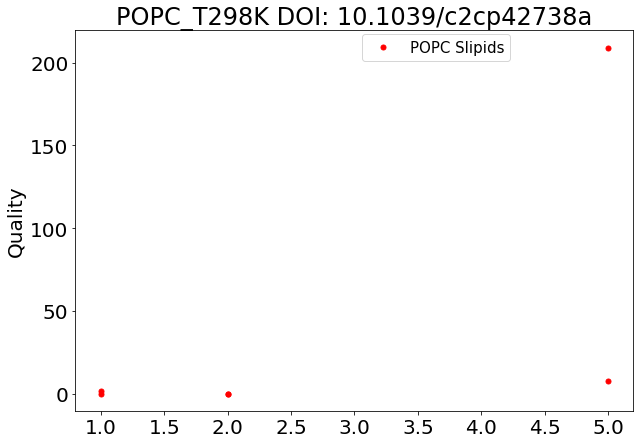

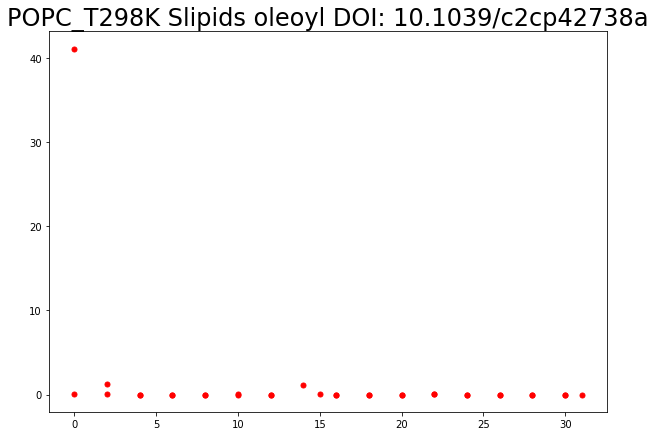

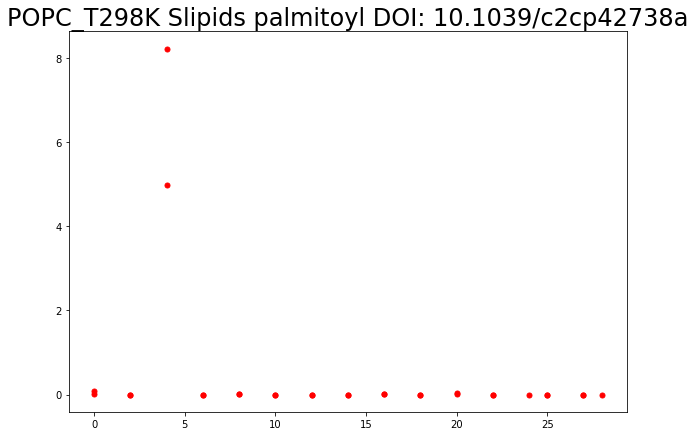

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

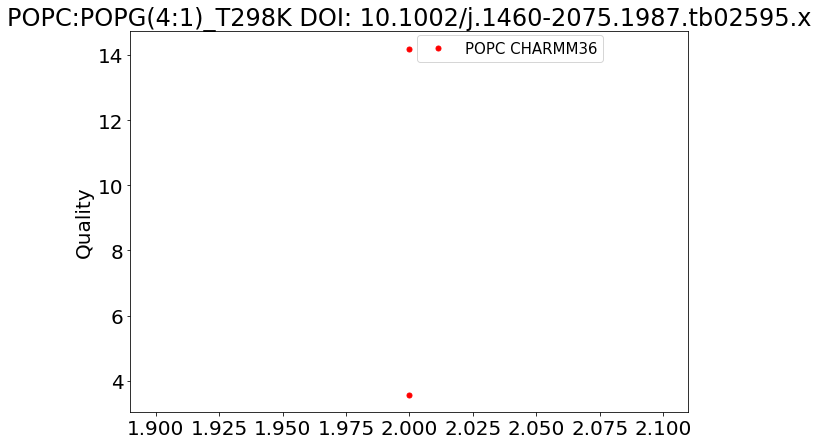

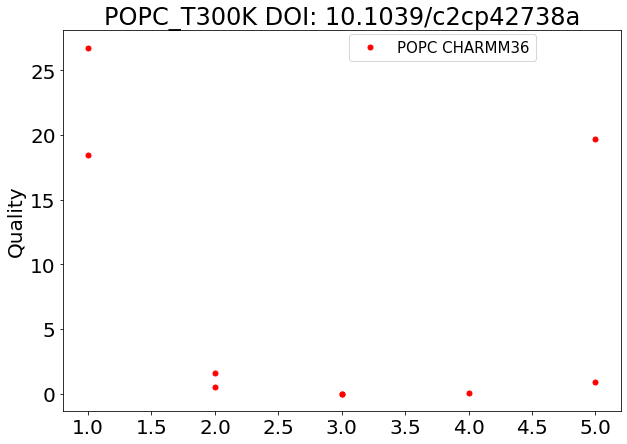

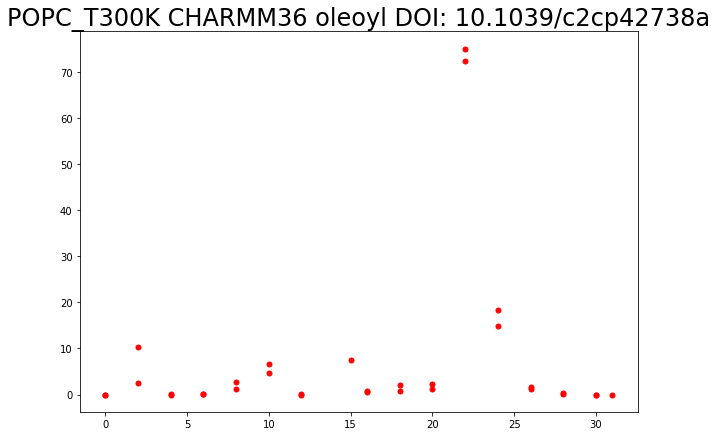

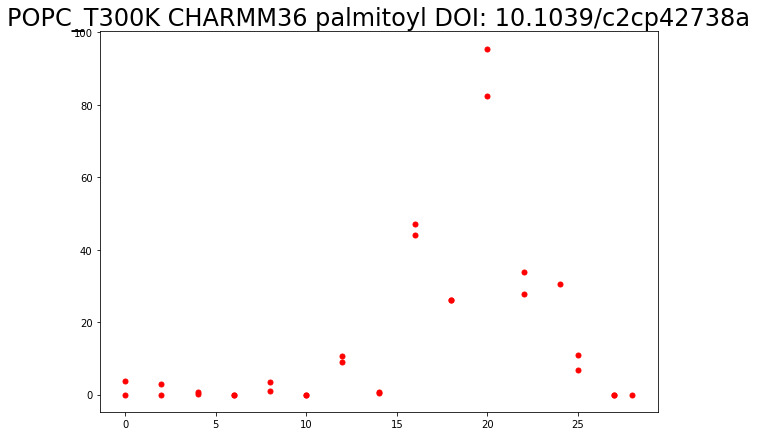

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

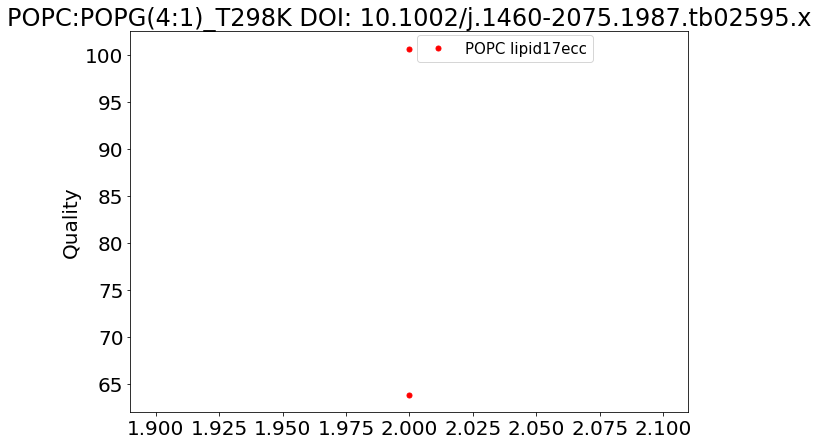

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

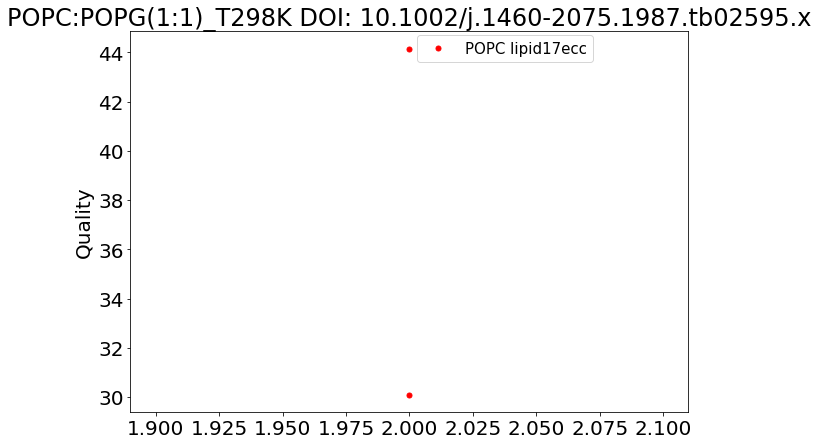

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

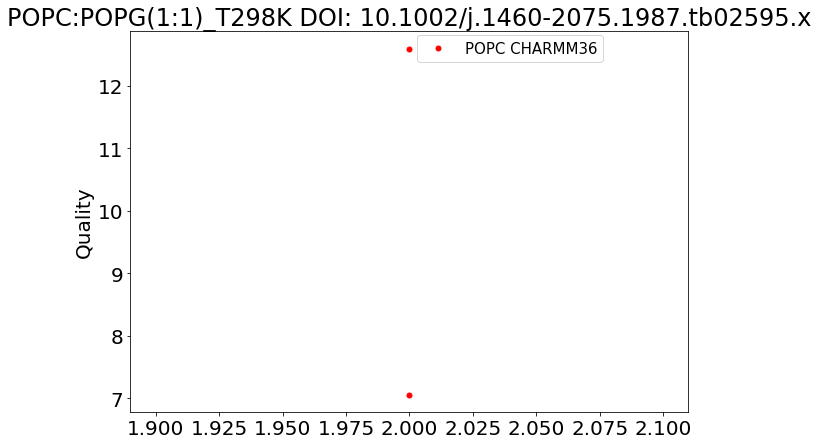

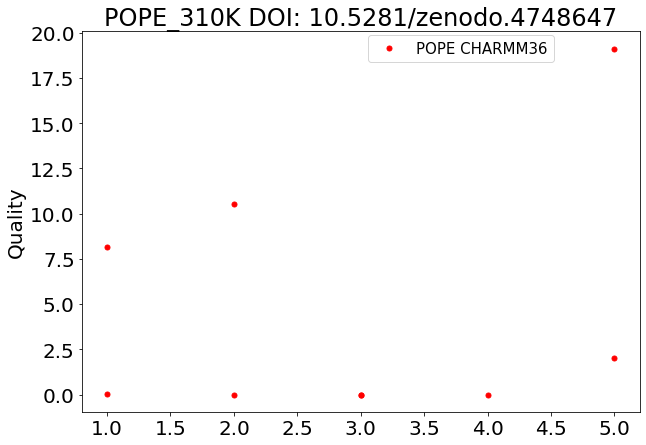

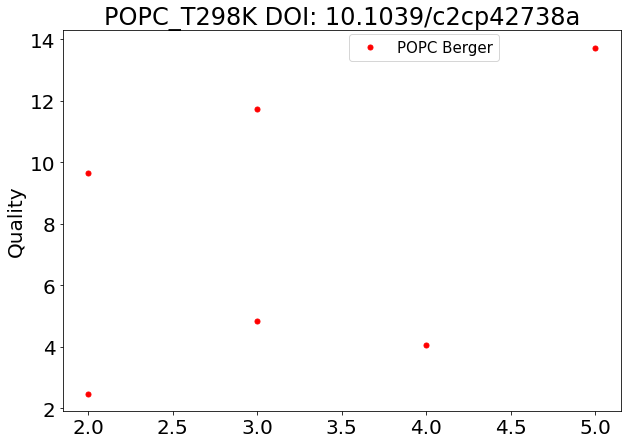

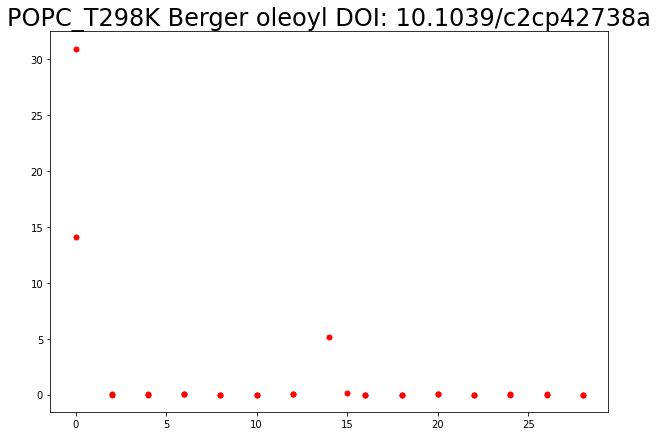

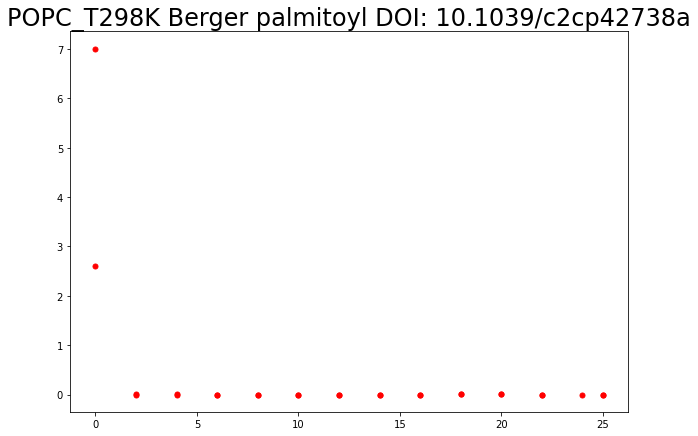

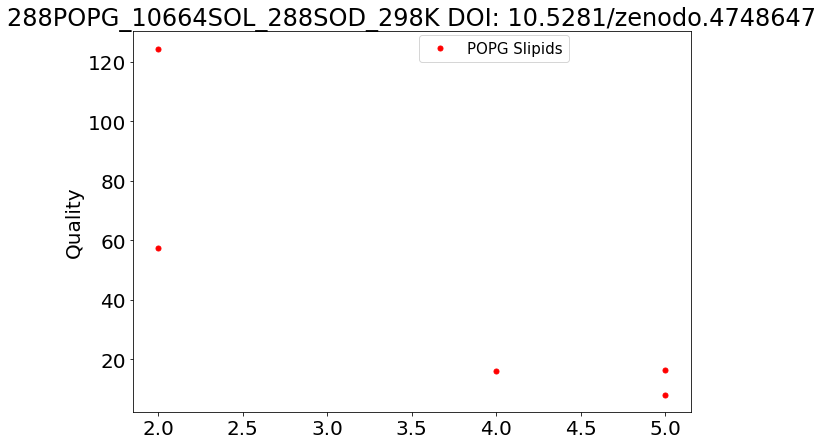

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

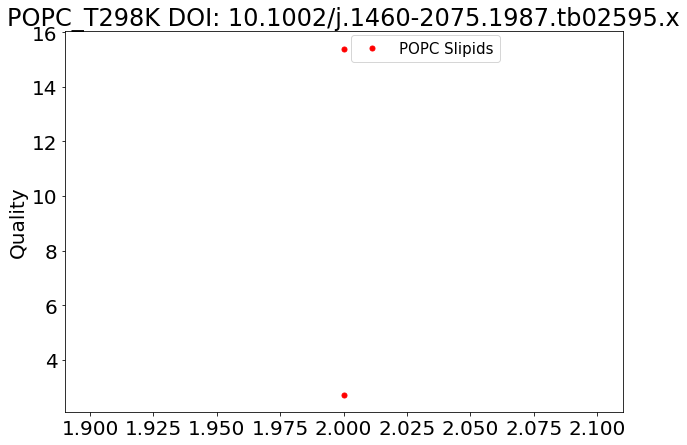

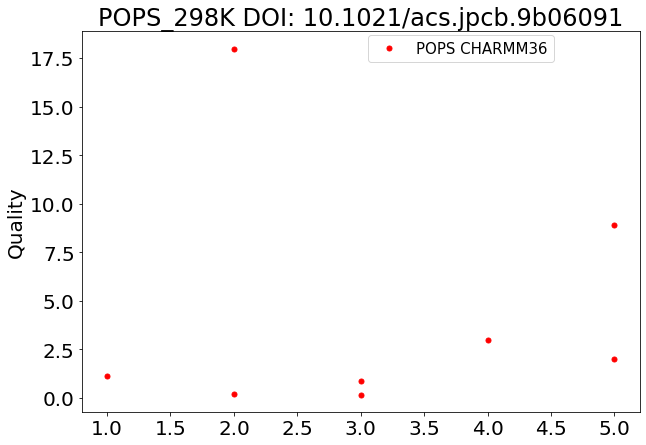

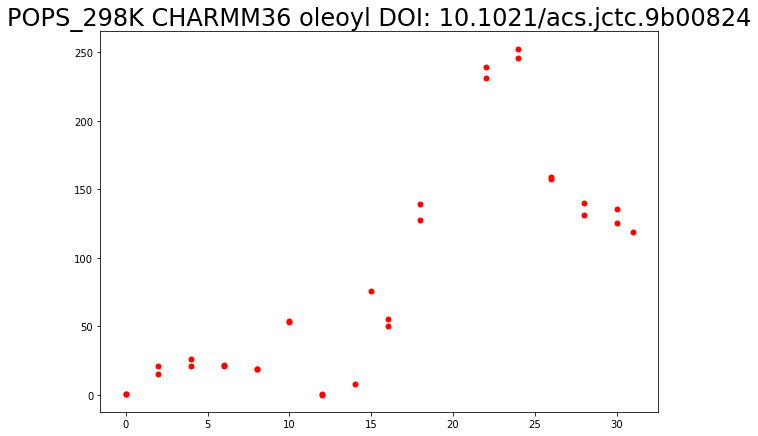

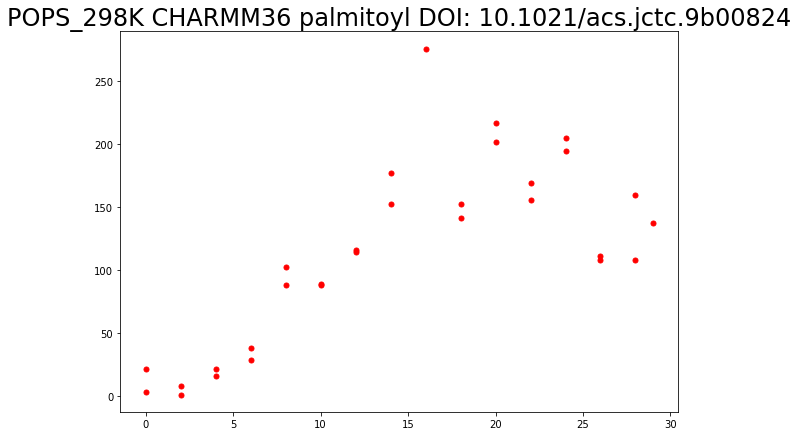

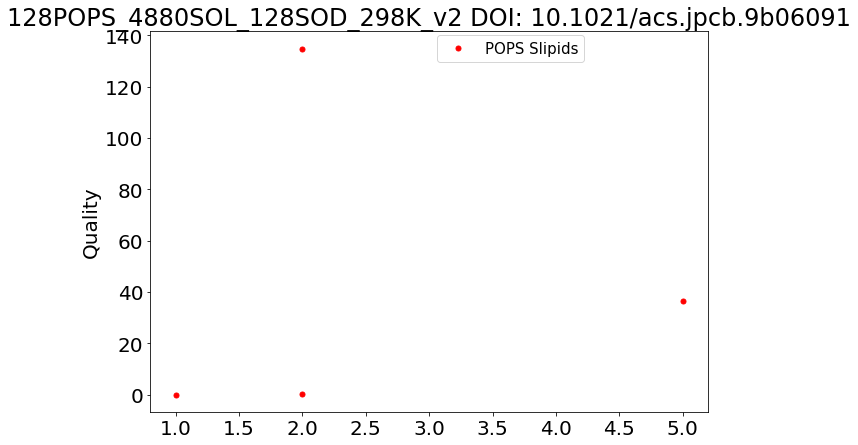

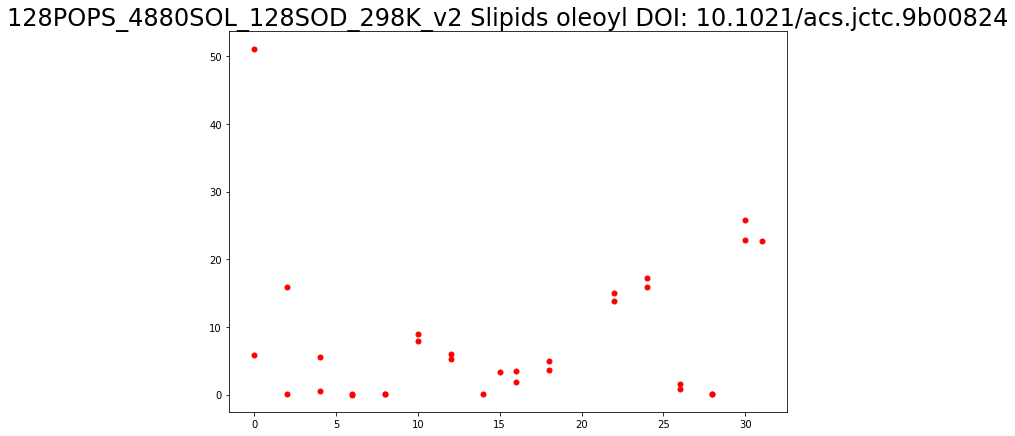

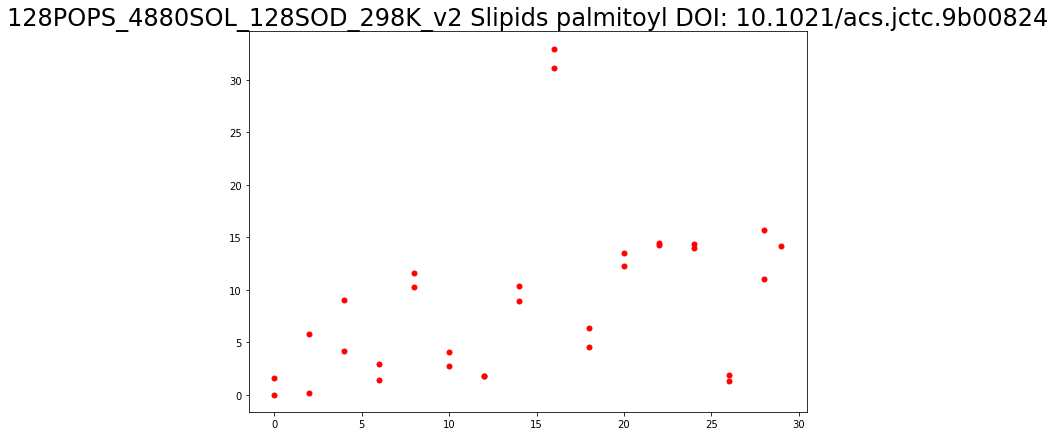

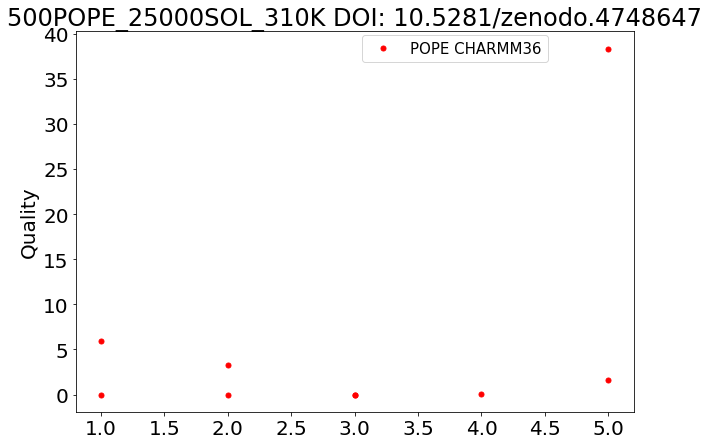

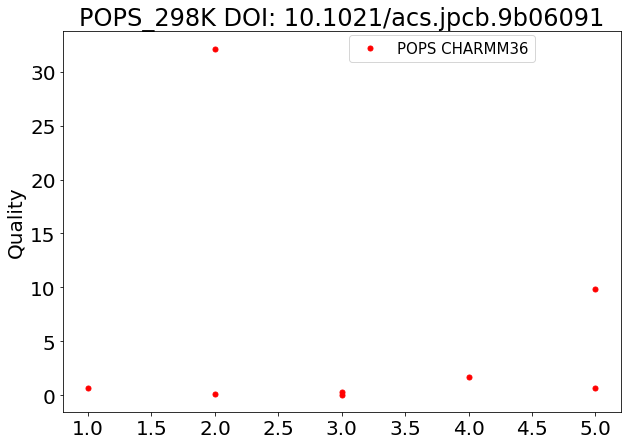

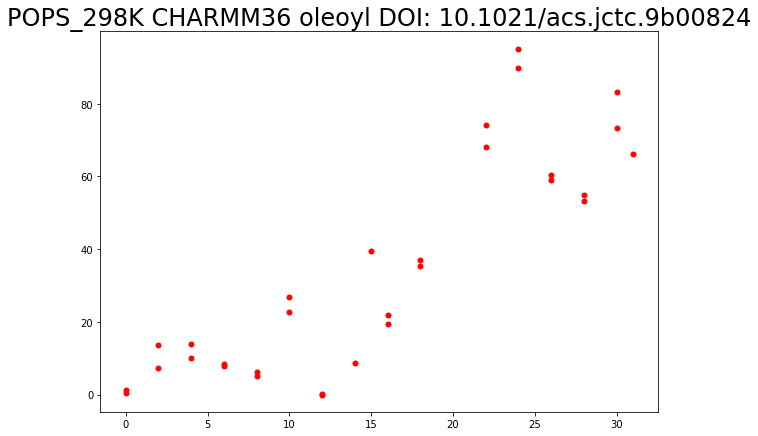

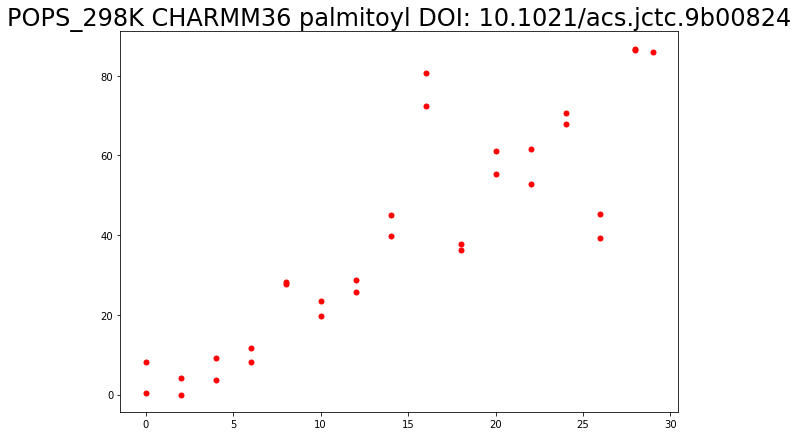

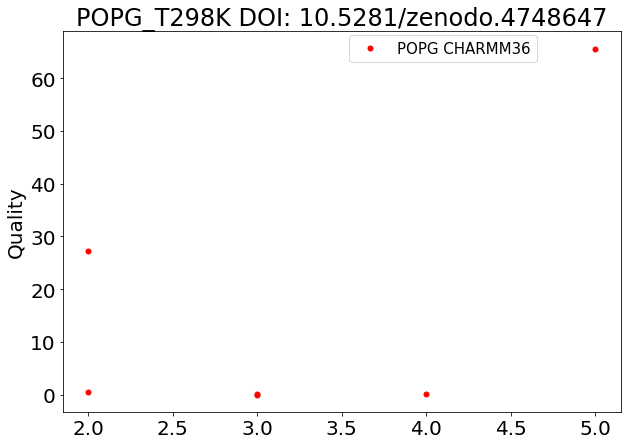

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

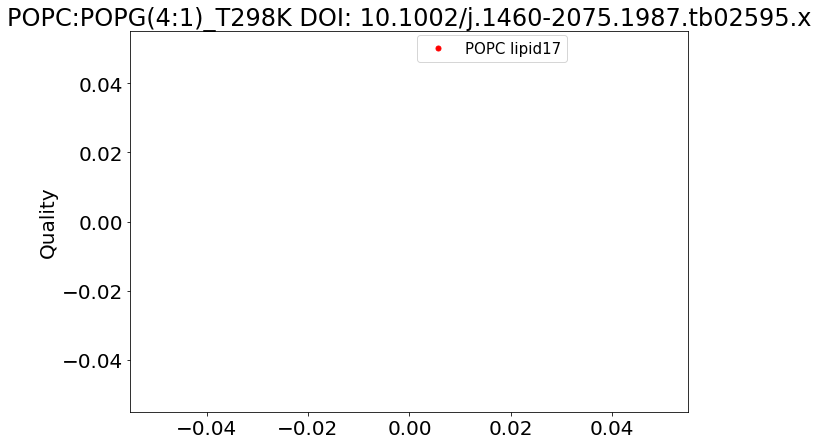

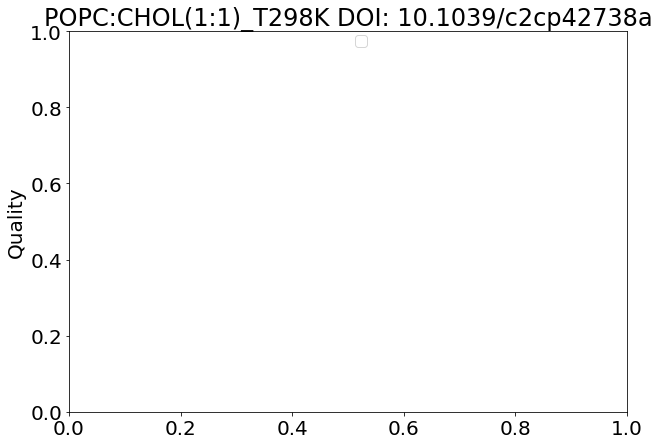

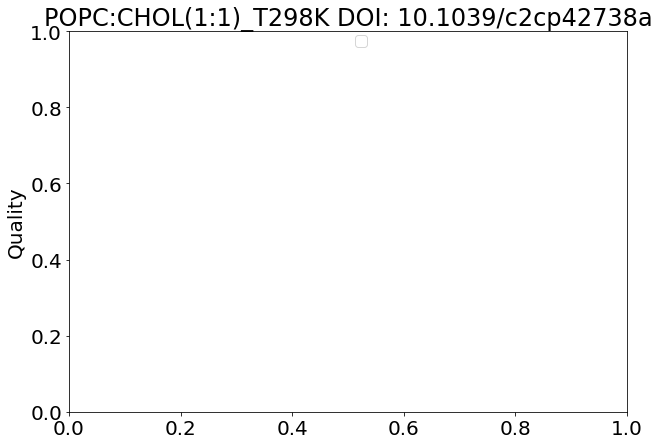

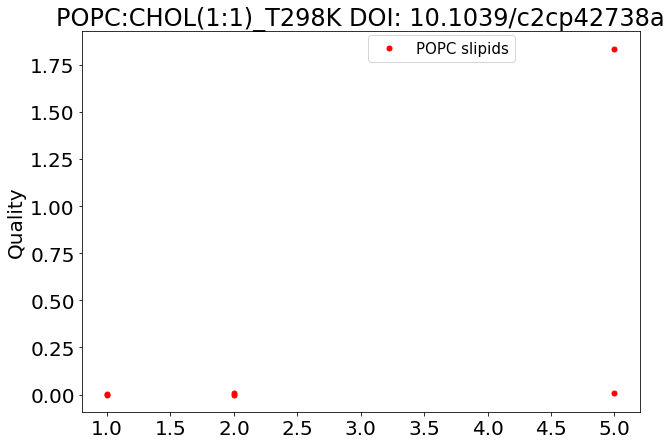

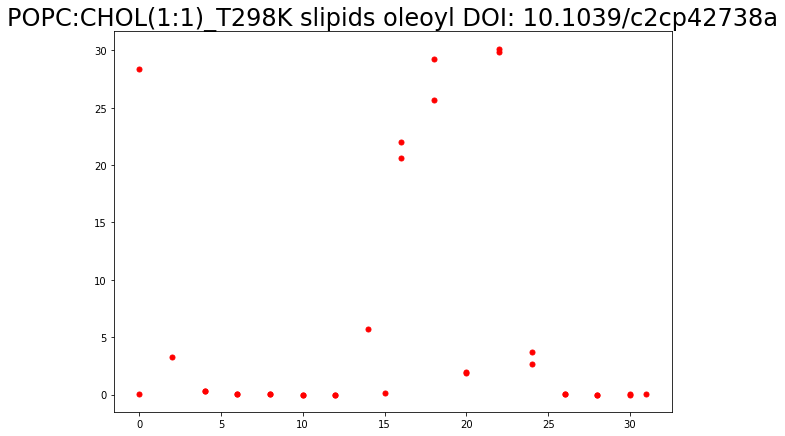

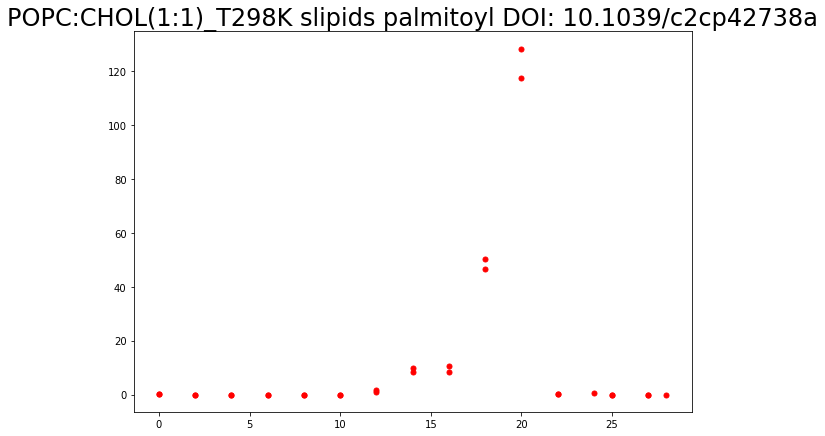

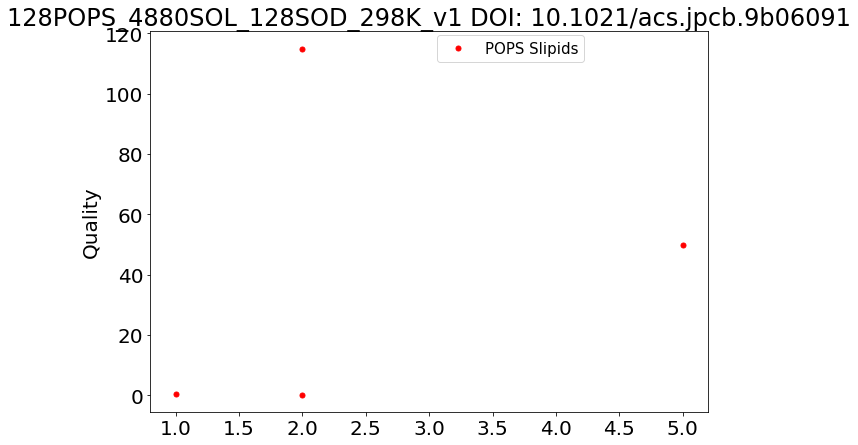

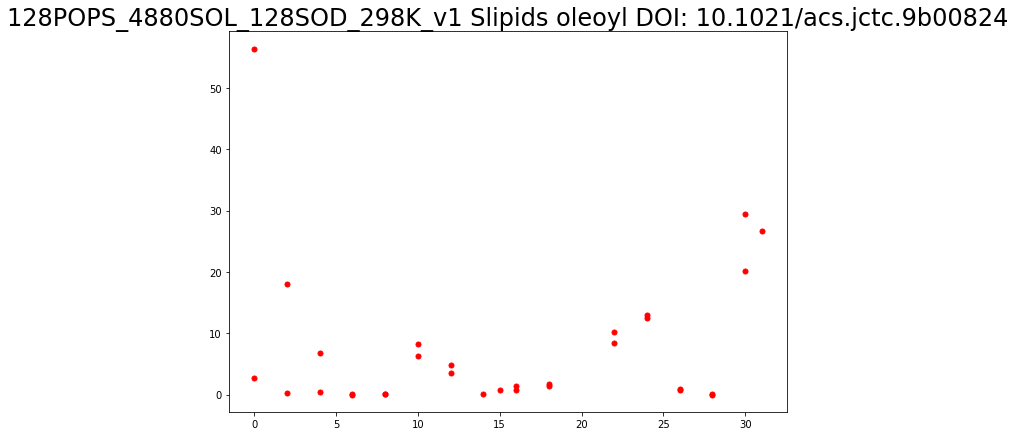

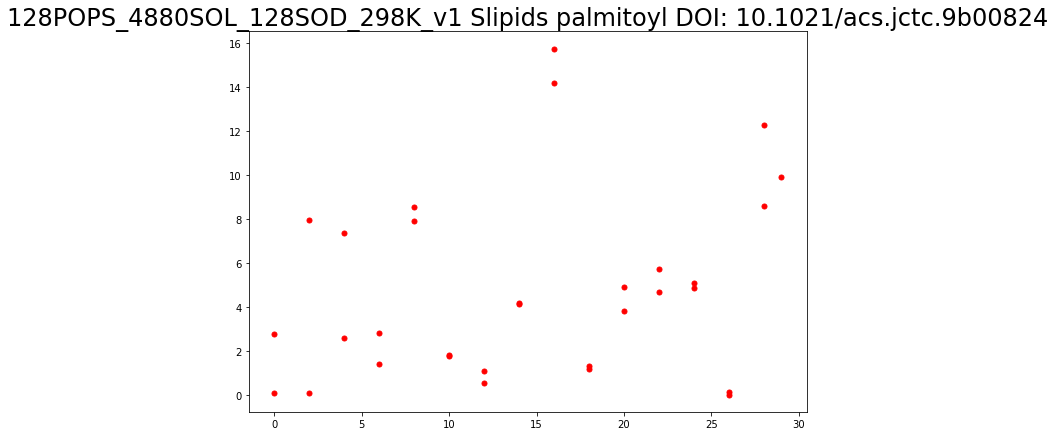

In [6]:
10.1021/jacs.1c05549: 10.1021/jacs.1c05549/2    
def plotHeadGroup(readme, data, lipid):
    fig= plt.figure(figsize=(10,7))
    #print(data)
    for doi in data:
        RealData = data[doi]
        for key2, value in RealData.items():
            #print(key2,value)                    
            #plt.gca().invert_yaxis()
            #plt.ylim([0,1])               
            if lipid == 'POPG' and 'M_G3C6_M' in key2:
                l = None
                plt.plot(0,value[5],"s", color='red', label = l,marker=".", markersize=10)  #color=colors[i],
            if 'M_G3N6' in value: 
                l = None
                plt.plot(0,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C5_M' in key2:
                l = None
                plt.plot(1,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C4_M' in key2:
                l = None
                plt.plot(2,value[5],"s",color='red', label = l,marker=".", markersize=10)
            if 'M_G3_M' in key2:
                l = None
                plt.plot(3,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G2_M' in key2:
                l = lipid + " " + readme.get('FF')
                plt.plot(4,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G1_M' in key2:
                l = None
                plt.plot(5,value[5],"s",color='red',label = l,marker=".", markersize=10)
            plt.legend( loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            plt.ylabel('Quality', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            # plt.ylim(0,-1050)
            plt.title(readme['SYSTEM'] + " DOI: " + doi, fontsize=24)

    return fig



def plotTails(readme,data,name_tail):
    for doi in data:
        RealData = data[doi]
        keys_list = list(RealData.keys())
        tail = []
        if name_tail == 'palmitoyl':
            tail = [x for x in keys_list if 'M_G1C' in x]
        elif name_tail == 'oleoyl':
            tail = [x for x in keys_list if 'M_G2C' in x]
        
        if tail:
            fig1= plt.figure(figsize=(10,7))
            previous_key = ""
            for index, key in enumerate(tail):
                #plt.gca().invert_yaxis()
                #plt.ylim([0,1])
                if key[0:-3] == previous_key[0:-3]:
                    plt.plot(index-1,RealData[key][5],"s",color='red',marker=".", markersize=10)
                else:
                    plt.plot(index,RealData[key][5],"s",color='red',marker=".", markersize=10)
                if key[0:-3] != previous_key[0:-3]:
                    previous_key = key
            plt.title(readme['SYSTEM'] + " " + readme['FF'] + " " + name_tail + " DOI: " + doi, fontsize=24)
            # plt.legend(loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            # plt.ylabel('Quality', fontsize=20)
            return fig1
        else:
            print('No quality data for acyl tails')
            return ""

for system in systems:
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    for files in os.walk(path):
        #for file in files[2]:
        #    print(file)
        OPdata = {}
        for filename2 in files[2]:
            filepath2 = path + filename2
            if filepath2.endswith("_OrderParameters_quality.json"):
                lipid = filename2.replace('_OrderParameters_quality.json', '')
                #print(filepath2)
                with open(filepath2) as json_file:
                    OPdata[lipid] = json.load(json_file)
                json_file.close()
                #print(OPdata)
            
                #plot head group
                for key1 in OPdata.keys():
                    #print(key1)
                    data = OPdata[key1]
                    doi = readme['DOI']
                    #print(data)
                    plotHeadGroup(readme, data, key1) 
                    # plot oleoyl
                    name_tail = ["oleoyl","palmitoyl"]
                    plotTails(readme,data, name_tail[0])
                # plot palmitoyl
                    plotTails(readme,data, name_tail[1])
            

# Plot form factors with experiments

../../Data/Simulations/1b2/6e6/1b26e6c750b4f39c37770422cd4d3c40240cf111/995bc873b811ca09c916b47784fa33bb9d793732/
{'POPS': {'NAME': 'POPS', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPScharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 4480, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}, 'SOD': {'NAME': 'SOD', 'COUNT': 128, 'MAPPING': 'mappingSOD.txt'}} CHARMM36 1259.961798902994 21.683722277315916


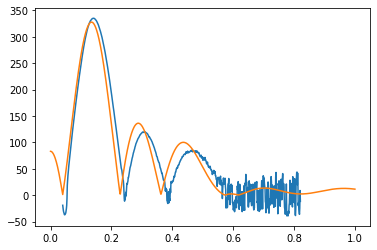

../../Data/Simulations/16a/a70/16aa70c118dbfdbb7bd8e0462575e2776e0dec9a/ba8633f6385dbf4c344b8a7580603620b0d52603/
{'CHOL': {'NAME': 'CHL1', 'COUNT': [40, 40], 'MAPPING': 'mappingCHOLESTEROLcharmm.txt'}, 'POPC': {'NAME': 'POPC', 'COUNT': [40, 40], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4496, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 772.6664279123403 75.43301102088454


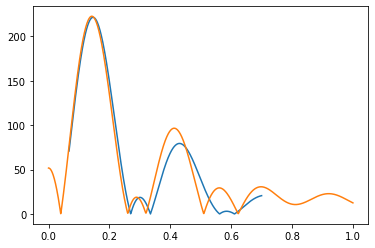

../../Data/Simulations/436/81a/43681aac9491f23ea55f7cdf39b5df580f8e0279/c89a204992c50aa5c464e5ef5b4981c3b24fbe13/
{'CHOL': {'NAME': 'CHL1', 'COUNT': [61, 61], 'MAPPING': 'mappingCHOLESTEROLcharmm.txt'}, 'POPC': {'NAME': 'POPC', 'COUNT': [61, 61], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 9760, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 929.4209898008041 75.09253797284677


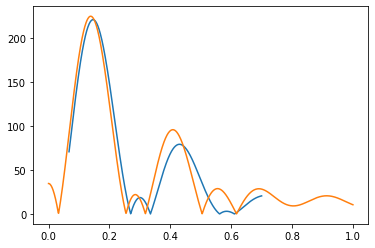

../../Data/Simulations/371/d53/371d534a1bb41fd81e137717e473e6916c9bbf70/7c24007a3d9cbe605a31999850e929ebfaf530f7/
{'POPS': {'NAME': 'POPS', 'MAPPING': 'mappingPOPSmacrog.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 4480}, 'SOD': {'NAME': 'NA', 'MAPPING': 'mappingNA.txt', 'COUNT': 128}} MacRog 1376.2089303790156 21.950025993251213


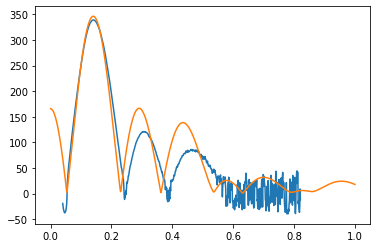

../../Data/Simulations/ca4/038/ca403878babec6f48159c1355f202089c0fd7fc0/81adbfa5c49ae97cb93b9bbe06fa673662c1a44a/
{'POPE': {'NAME': 'POPE', 'MAPPING': 'mappingPOPEslipids.txt', 'COUNT': [168, 168]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 13460}} Slipids 140.08716462112065 82.55703426134542


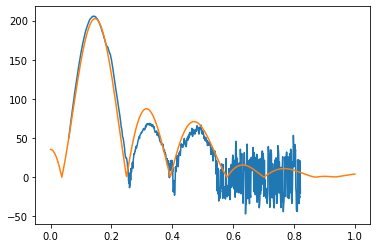

../../Data/Simulations/eba/d7b/ebad7bde0e3d5e5fcc3a64387f569e10162fe7c0/9caac3eaf3998263deea32cbee2b2f947d38dcea/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPClipid14_POPCres.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 5120}} Lipid14 with Verlet scheme 553.9990496368638 74.90468872021304


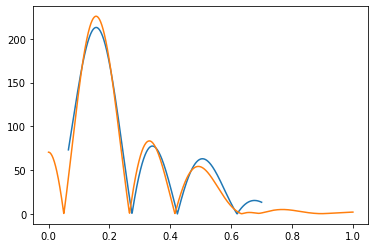

../../Data/Simulations/90f/90b/90f90b7a9097418bd99f312299cf76f3ca86e403/e6620192a44308917b63dd11a7e7c34c1c8aa131/
{'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 9000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 467.35915176939284 104.32889703586645


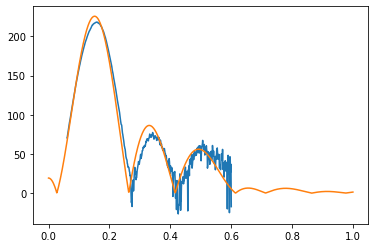

../../Data/Simulations/6a7/ee8/6a7ee8ec651f41dbaa4460d095ad2e30b27de20b/9b33210b33f94f175df15b16f5064d9464900b05/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCMaciejewskiRog1.txt', 'COUNT': [144, 144]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 14400}} MacRog 674.0214848353106 67.47667604260576


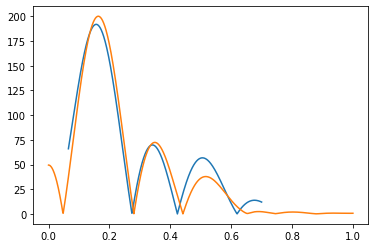

../../Data/Simulations/b7a/4c6/b7a4c62a0f6112eb07c99e3fe912bd5e55e1dca2/5e824ebda9f3c3341685c5aa5a3ff3ad7ead34f5/
{'SOL': {'NAME': 'SOL', 'COUNT': 25000, 'MAPPING': 'mappingTIP3Pwater.txt'}, 'POPE': {'NAME': 'POPE', 'COUNT': [250, 250], 'MAPPING': 'mappingPOPEcharmm.txt'}} CHARMM36 234.33908127271874 95.74916430417967


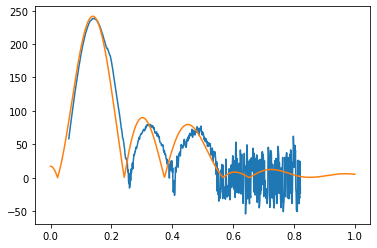

../../Data/Simulations/d87/a78/d87a78ec32678473762aebb21acac182b28dd9dc/f03ec6ba87add363b18d0fff9c03213bcafa3753/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 198.79554070616825 106.58183454651353


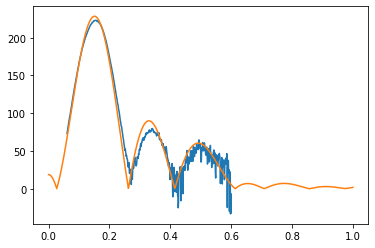

../../Data/Simulations/ba8/888/ba888896d74d078c25b29ae4c106c0096146205f/7ac0f9ece8f6b64afaefad36e542a4162bac4b33/
{'POPE': {'NAME': 'POPE', 'MAPPING': 'mappingPOPEslipids.txt', 'COUNT': [168, 168]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 13460}} Slipids 136.68006141315806 82.26965277641236


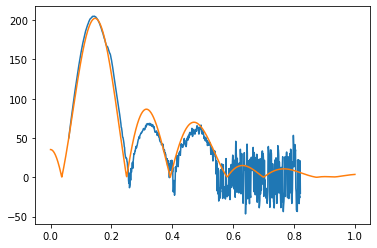

../../Data/Simulations/8cb/989/8cb989e1813b93d1144d731ffbbc04a5cfcfb6a6/2db4e1d512355edd21cedbc0d28a45659dd6faa9/
{'CHOL': {'NAME': 'CHL1', 'COUNT': [128, 128], 'MAPPING': 'mappingCHOLESTEROLslipid.txt'}, 'POPC': {'NAME': 'POPC', 'COUNT': [128, 128], 'MAPPING': 'mappingPOPCslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 20334, 'MAPPING': 'mappingTIP3Pwater.txt'}} slipids 754.5863617133949 67.71378021626106


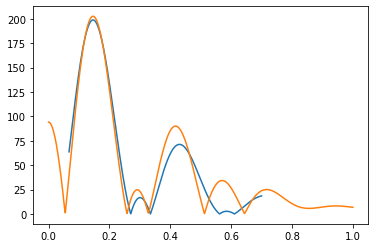

../../Data/Simulations/814/7cf/8147cf489ede30f8e44247cb5f5b2b3a72649d88/1cb6538530c40abb28ad1480cb53f8faca939de8/
{'POPC': {'NAME': 'PC', 'MAPPING': 'mappingPOPClipid14.txt', 'COUNT': [36, 28]}, 'CHOL': {'NAME': 'CHL', 'MAPPING': 'mappingCHOLESTEROLlipid14.txt', 'COUNT': [32, 32]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingwaterlipid14.txt', 'COUNT': 3968}} Lipid14 1622.2852044771516 47.45922922615802


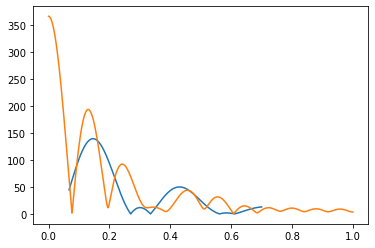

../../Data/Simulations/174/c74/174c746e212577c63e6df6c6910b2e9a1d587241/6fb923ea75663dbeea13c0fa79015ae11dea9157/
{'DPPC': {'NAME': 'DPPC', 'COUNT': [256, 256], 'MAPPING': 'mappingDPPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 20480, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 194.96962948870427 99.55081822876117


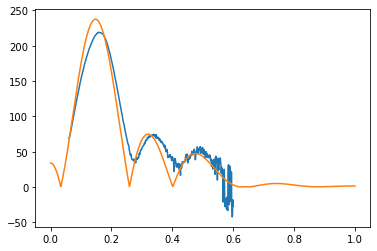

../../Data/Simulations/74f/eeb/74feeb08b7b5b2dcf54639ef1c51b9d2c4731c81/17067c369e136d719304061da5b010059645e3bf/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 192.44187052657875 106.97752471677643


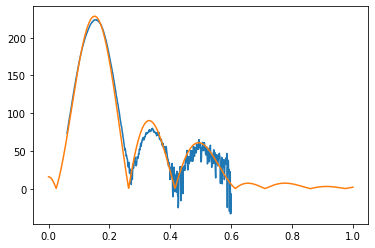

../../Data/Simulations/bd9/801/bd98012f8548b7c22429790489240ca0e79aeb83/0fd7285aeef1d21f45deec3262aa06cd18f50df5/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 197.28198894629998 106.6792509063237


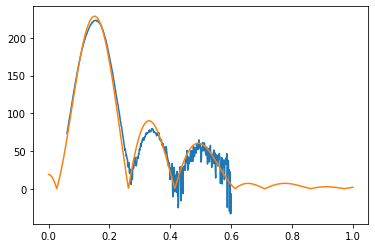

../../Data/Simulations/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a5a7377c8a46341eba603f320cf7/
{'POPS': {'NAME': 'POPS', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPScharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 4480, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}, 'SOD': {'NAME': 'SOD', 'COUNT': 128, 'MAPPING': 'mappingSOD.txt'}} CHARMM36 1696.4942228017253 22.461454212208483


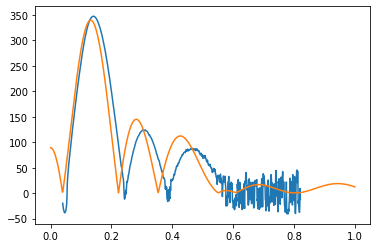

../../Data/Simulations/93f/385/93f3857977ebbdf869cd4457fbfad82f48e8f304/797a337035d641067dadb714f6fc7cc40a2bcccc/
{'CHOL': {'NAME': 'CHL1', 'MAPPING': 'mappingCHOLESTEROLslipid.txt', 'COUNT': [76, 78]}, 'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [179, 179]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 21183}} Slipids 650.827712481402 72.6245443234207


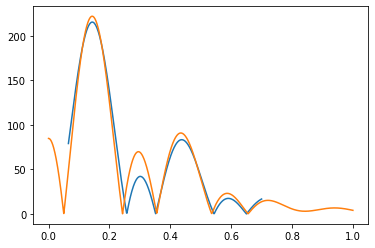

../../Data/Simulations/bcf/4b1/bcf4b194b7312e8a2e8001a271bc4e6f1a7ec02d/23bf9b7088bceeb0d6a99884d4bc9acfd8dd60c4/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 201.92558764387803 106.90516512147516


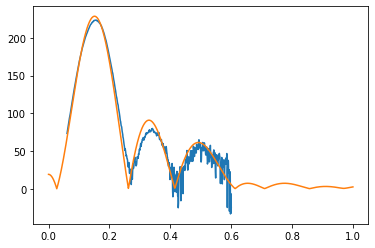

../../Data/Simulations/7cf/9df/7cf9df0cc6fe319d93e3f5635b2c6b517513cbf5/b1e8bdfc572caaf640f503bff2726ed0a1a793a3/
{'POPC': {'NAME': 'POPC', 'COUNT': [36, 36], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2239, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions) 247.50442451725135 109.36383589419113


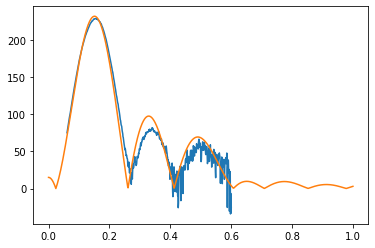

../../Data/Simulations/102/dfa/102dfa390326acd775347b1d703ccfa85e033cd8/1ad80d5d253e861f01d8f16e0d1590c6ef962916/
{'POPC': {'NAME': 'POPC', 'COUNT': [128, 128], 'MAPPING': 'mappingPOPCberger.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 10342, 'MAPPING': 'mappingSPCwater.txt'}} Berger 304.31884620138914 111.11947606530056


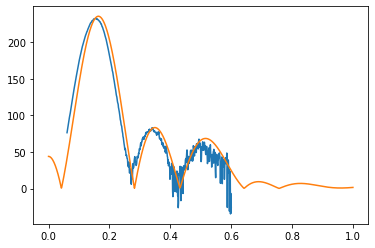

../../Data/Simulations/eb4/ab4/eb4ab41fb73a8dfefe1cda75ecc5b036a169f04b/2e9d5a4f3e0a953aa3855e2470ebc83fb0a54dd7/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPClipid14_POPCres.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 2234}} Lipid14 251.8747599130568 103.09409182088822


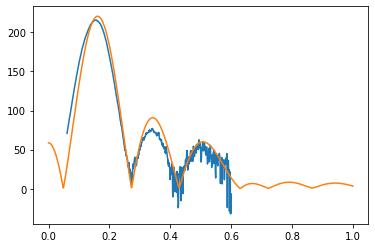

../../Data/Simulations/4db/c54/4dbc5440f1defe65905225286b9b446aa37082ad/8f5313af34f02d15f819a0d0dc843a780af3da87/
{'POPC': {'NAME': 'POPC', 'COUNT': [36, 36], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2239, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions) 524.2521367422262 107.79077250668155


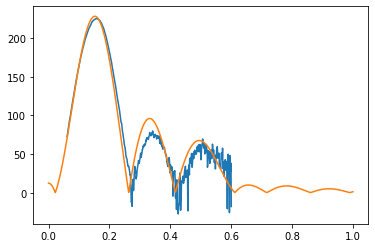

../../Data/Simulations/116/9a0/1169a0f959c9caac1671425c8ae4cd6e255dc49f/e0dbaa355f6b5faeeef73dd79514eb8364492a88/
{'DPPC': {'NAME': 'DPPC', 'COUNT': [36, 36], 'MAPPING': 'mappingDPPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2880, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions) 210.36067070833653 108.99836491467721


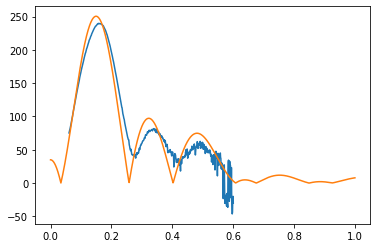

../../Data/Simulations/7af/288/7af288083118561ffb3a586b361e49f0a5a751af/fb9a5ab02b984b80b916d1fc7d7fc2363d08e800/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [250, 250]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 25000}} Slipids 430.2247771776125 91.18665289037858


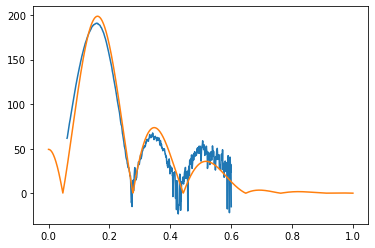

../../Data/Simulations/b58/0d1/b580d13983ed1b38cf975bc3f129c58bf05efd5a/244f4bc5e15f39de659fa2b13e30cd833084af44/
{'POPE': {'NAME': 'PE', 'MAPPING': 'mappingPOPElipid17.txt', 'COUNT': [250, 250]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingTIP3Plipid17.txt', 'COUNT': 25000}} Lipid17 264.4392350315357 101.58591528878388


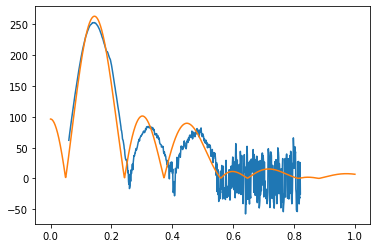

../../Data/Simulations/8b4/def/8b4defac09883665a8c2e32302d5080664fc77aa/f0b754bfeb545d99e3d319216c6894adbf27fee2/
{'DPPC': {'NAME': 'DPPC', 'COUNT': [36, 36], 'MAPPING': 'mappingDPPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2188, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions) 212.41009633417474 108.85487058248535


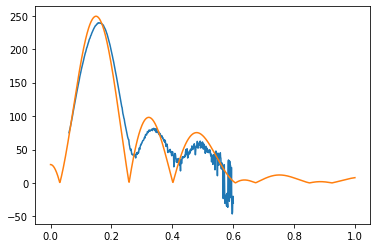

../../Data/Simulations/e7b/a4b/e7ba4b167ed159f63ce55d7a6e6e7536d9fe93cd/48cb3719c54af93939a92567b276f9042a9abaf6/
../../Data/Simulations/b04/7ff/b047ffe7ca543800f5d13bc850bbb66924b7231b/76a77f734fea9fcca1189a8c5b4533a68d73ead5/
../../Data/Simulations/256/b0c/256b0c2225ce6947b66b5a32c878ab4a46eb4e1a/ac93914e3714a2bb315ba4bf75c9b4b3f9db6607/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4040, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 193.06173708761256 106.92556890535414


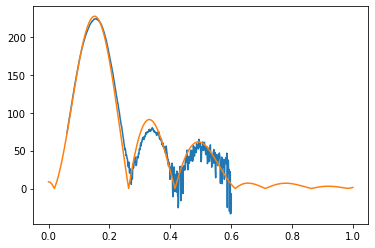

../../Data/Simulations/2e9/c2b/2e9c2b5fcf3b5504ff9fd97c893d20081f72a5fc/71f038f911d296a0407c424def4d6d6a6c69ea6c/
{'POPC': {'NAME': 'POPC', 'COUNT': [36, 36], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2880, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 (center of mass removed independently for upper leaflet, lower leaflet and water+ions) 525.2161457296274 107.82411363757457


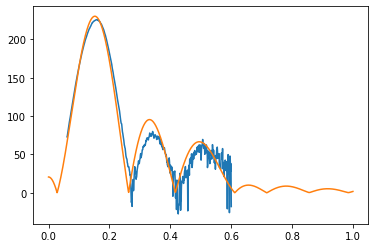

../../Data/Simulations/1d8/4fd/1d84fd1f2981492c978058d35c31876f932def55/4e032d4b41fe6a7d69a7ec3920115b404c97df03/
{'CHOL': {'NAME': 'CHL1', 'MAPPING': 'mappingCHOLESTEROLslipid.txt', 'COUNT': [61, 61]}, 'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [61, 61]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 9760}} Slipids 649.998695644255 68.70657869432972


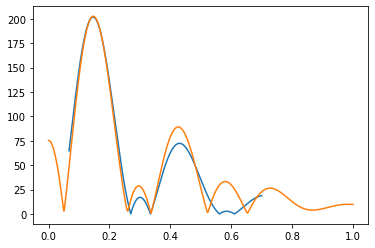

../../Data/Simulations/35d/d6b/35dd6bcb5bf03400b81c070292e36025c48dc1a6/3d0ca721c24d7f22d09178f10f1dd89a333dfe07/
../../Data/Simulations/225/02e/22502e7ac9fc0c6b000bbaf11c853b15aea4da61/71e868c8cfd294df5b3678d9ce7401621825d218/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4040, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 194.34806759880803 106.64327826337286


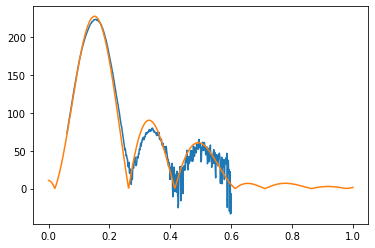

../../Data/Simulations/310/972/310972e588b9d3b8bb3049c5a4ee1977889c6559/a4d8e0ad017d67cfb566b576d573778c671c4cba/
{'POPS': {'NAME': 'POPS', 'MAPPING': 'mappingPOPSmacrog.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 4480}, 'SOD': {'NAME': 'NA', 'MAPPING': 'mappingNA.txt', 'COUNT': 128}} MacRog 1563.9633081093432 22.28640131566078


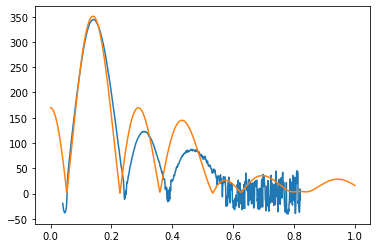

../../Data/Simulations/f62/739/f627391cd6cddf82078a7a12c4cd22767535b6fe/d9c93bb0ae93ede37c230593a348691012519efc/
../../Data/Simulations/bfa/add/bfaadd3db34555a7cb9c66667493f5b534350c7d/3932a021491cd526f760fe7b872b92c780a4cddc/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 211.48413143170788 107.17104120359356


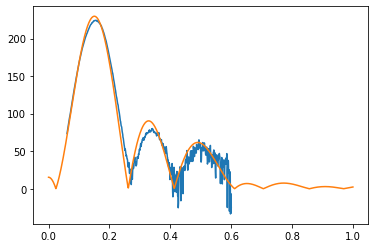

../../Data/Simulations/b16/7e2/b167e26f39a390c69bc605c2217f732d854c6395/f5de1720a24e1896cf96afc94fc4ef028adc47d0/
../../Data/Simulations/5d3/ea3/5d3ea34ae3507e1e3332ae8796a6e9de530fd8e0/88949910e27ce2d96c8bb232b2b7647236920e31/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4040, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 190.64483155015031 105.99909968381203


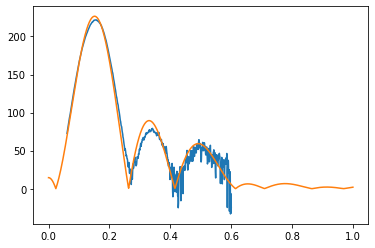

../../Data/Simulations/95c/736/95c7369066c86ec65669e86bf250814c3bdb6033/0f4d4825670af2e814557030787f14a3f376d6ea/
{'DPPC': {'NAME': 'DPPC', 'COUNT': [36, 36], 'MAPPING': 'mappingDPPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2189, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 205.66787154828265 108.2197940566797


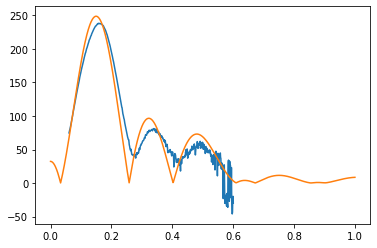

../../Data/Simulations/d45/b05/d45b05bc99386840c573e3d7267667afe16526fe/720a899e06ba483b86b0158f41ec691559f72939/
{'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'water', 'COUNT': 10456, 'MAPPING': 'mappingTIP4Pwater.txt'}} CHARMM36 396.4199523575016 103.22291809765377


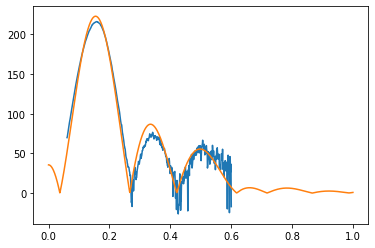

../../Data/Simulations/02b/984/02b98418d9965749ac943ecae9627cfdd1dfbdcd/7339faa76da6c93cfee03e59f399e2eed1628b53/
{'POPS': {'NAME': 'POPS', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPSslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4480, 'MAPPING': 'mappingSPCwater.txt'}, 'SOD': {'NAME': 'NA', 'COUNT': 128, 'MAPPING': 'mappingNA.txt'}} Slipids 328.8879598119645 18.840788002863565


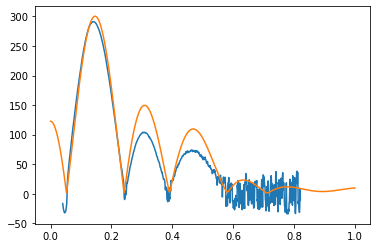

../../Data/Simulations/6d5/131/6d5131733214a5cdb69b1fa19d5e18a4b6694320/fac5ed76c777849ada7cde50ca64a6e06f0af9bc/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 189.15615959467928 106.5056499904756


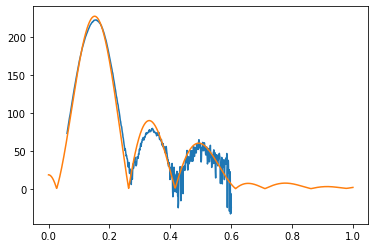

../../Data/Simulations/89d/a41/89da414cb29d949f428fda5cb6b91a217fc25a37/00d3801d4ed021bc79b766e016586f9ad4d38232/
{'POPC': {'NAME': 'PC', 'MAPPING': 'mappingPOPClipid14.txt', 'COUNT': [69, 39]}, 'CHOL': {'NAME': 'CHL', 'MAPPING': 'mappingCHOLESTEROLlipid14.txt', 'COUNT': [10, 10]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingwaterlipid14.txt', 'COUNT': 3968}} Lipid14 1299.2474755029568 56.66942591378871


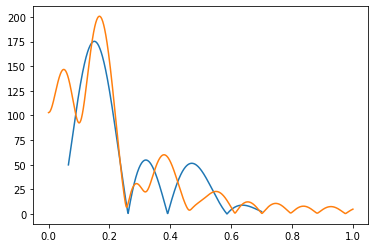

../../Data/Simulations/39b/eb6/39beb6ec9a40f78b9aaad0188ea679cdeeb83078/951177f7e152b408149e2ec4e16d660bccc94563/
{'POPC': {'NAME': 'POPC', 'COUNT': [61, 61], 'MAPPING': 'mappingPOPCslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4880, 'MAPPING': 'mappingTIP3PwaterSlipids.txt'}} Slipids 285.01952394648316 101.86405539790347


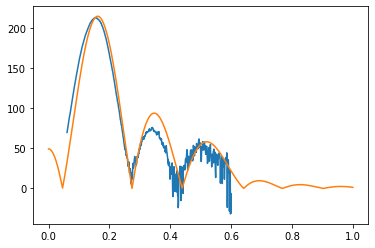

../../Data/Simulations/1ed/5f7/1ed5f76310f879efb0cb1c808289db94157f4c9d/2589bd4ed6da50afc223e26a5f214da1aae31e0c/
{'POPC': {'NAME': 'POPC', 'COUNT': [400, 400], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 36000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 511.69631629944774 97.67708298457879


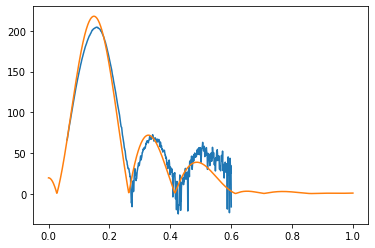

../../Data/Simulations/299/9ba/2999ba7a8e75cdcbd0493b035d620556aa9a57c5/a92f8b57bb117b56d3bb16edc0d69662e0517d31/
{'POPC': {'NAME': 'PC', 'MAPPING': 'mappingPOPClipid17.txt', 'COUNT': [250, 250]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingTIP3Plipid17.txt', 'COUNT': 25000}} Lipid17 506.66690334400374 93.31623212963476


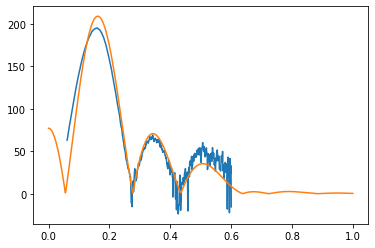

../../Data/Simulations/a3a/0de/a3a0ded0add42922c7cc7053c0ce04a1393babf8/29b917ed78df2dd6b117b3036c2c481e952185c9/
{'DPPC': {'NAME': 'DPP', 'MAPPING': 'mappingDPPCGAFFlipid.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 2197}} GAFFlipid 230.20079084598615 98.97665688872102


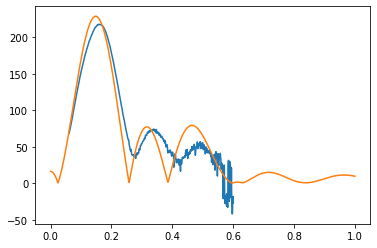

../../Data/Simulations/4e4/d45/4e4d45f15fc334edfa725ef670c7ec1f86589d3e/247e995fe4c17b8643ee8c9fb6760a383f65f024/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPClipid14_POPCres.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 6400}} ECC-lipids 522.754224548608 113.5510798739006


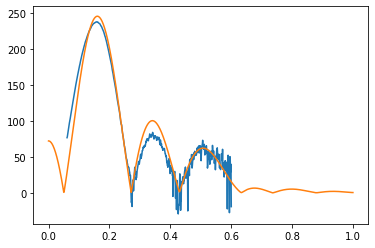

../../Data/Simulations/415/930/41593025f50adfceb2c888fed44afe0b1b7fe8da/34bafde4722aae82cc5972f9e30a54065d67159a/
{'POPE': {'NAME': 'POPE', 'MAPPING': 'mappingPOPEslipids.txt', 'COUNT': [250, 250]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 25000}} Slipids 122.1683654118914 84.28069452604565


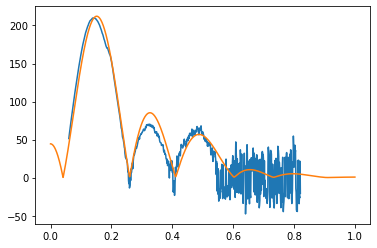

../../Data/Simulations/874/256/87425634a08154ef405aea238908c2891031d54c/17afdd19e48164c2b201d4cc9bfef1ccf06cd281/
{'POPC': {'NAME': 'POPC', 'COUNT': [250, 250], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 25000, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 432.605769792108 97.53193632730277


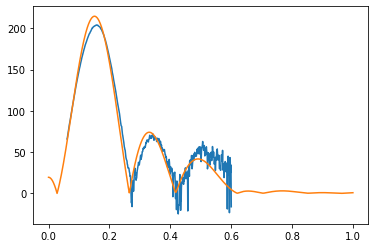

../../Data/Simulations/d56/af7/d56af76f2bc3c77ecb6b255dd1e6e4a304621a22/98cde4f05842054793d2430b174329e176982042/
{'POPC': {'NAME': 'PC', 'MAPPING': 'mappingPOPClipid14.txt', 'COUNT': [49, 35]}, 'CHOL': {'NAME': 'CHL', 'MAPPING': 'mappingCHOLESTEROLlipid14.txt', 'COUNT': [22, 22]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingwaterlipid14.txt', 'COUNT': 3968}} Lipid14 1743.3217616550596 56.51468947943868


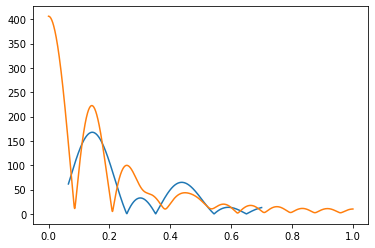

../../Data/Simulations/d0a/acf/d0aacf2392a074c84c540c30058708ec75394c32/64c2fa23c30e1f8471d6686ac85846875094a9d4/
../../Data/Simulations/b4f/866/b4f866c0dabffa6cd891e91841591d46590f34aa/a231c358dd8c0b7bb4cf558ccdbf022373354a9a/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 203.24705975075946 106.55770960354212


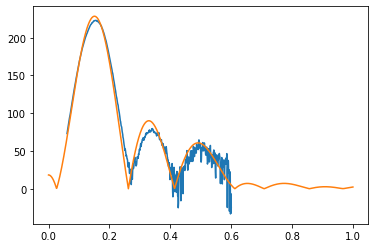

../../Data/Simulations/2d4/61b/2d461bc9d828af155146162ef42438974e4cbeaf/c8ce4cc36ef6ec7a085cf011176a92d9d746a792/
{'SOL': {'NAME': 'TIP3', 'COUNT': 5760, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}, 'POPE': {'NAME': 'POPE', 'COUNT': [72, 72], 'MAPPING': 'mappingPOPEcharmm.txt'}} CHARMM36 197.03421727641583 98.70921182538306


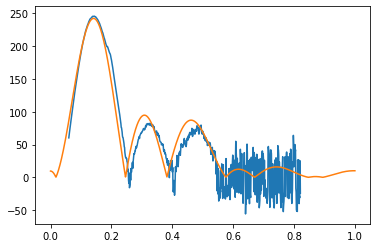

../../Data/Simulations/5fc/43a/5fc43ad145381cb3771e74353a36856ff8e65d2f/a17d97babec638e6f00c218e2582afa04e6ae5d4/
{'POPC': {'NAME': 'POPC', 'COUNT': [61, 61], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 4880, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 206.1930469041557 107.105004803552


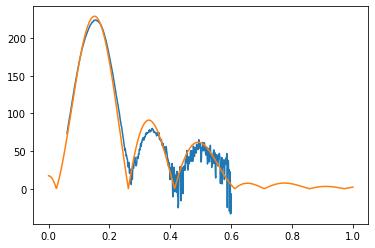

../../Data/Simulations/1a0/b6e/1a0b6e4b7e964cb51a2166ffdec28a9628a66213/4cc5c88c00d71f3431d40ab68d66e10039b03155/
{'DPPC': {'NAME': 'DPPC', 'COUNT': [36, 36], 'MAPPING': 'mappingDPPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2880, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 215.93826260074437 109.28373177972384


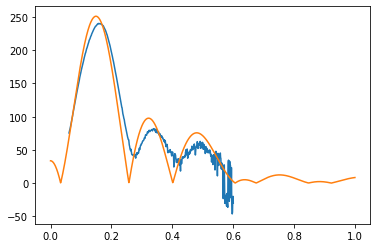

../../Data/Simulations/a33/b16/a33b16c62911e46c6cfeffc5c1cbf9eeb548da67/c8e02bee0bb725a95396e3d471060434dba329e6/
{'POPS': {'NAME': 'POPS', 'MAPPING': 'mappingPOPScharmm.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 3600}, 'SOD': {'NAME': 'NA', 'MAPPING': 'mappingNA.txt', 'COUNT': 72}} ECC-lipids, SPC water model, ECC-ions 297.2142286520776 19.788081137545532


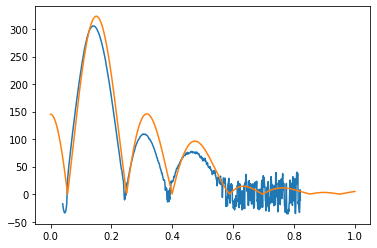

../../Data/Simulations/c2f/cb0/c2fcb067df2e1da3432eff195988b7213da19e4f/e1accdc68e32ff10512badff0fb466be197b4534/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCMaciejewskiRog3.txt', 'COUNT': [143, 145]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 12600}} MacRog 495.07943083014027 92.09074549428955


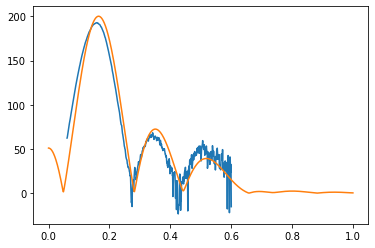

../../Data/Simulations/fb9/c8d/fb9c8d1e7ff7d08126c4ab7bb2ccbc55b6093afe/4eb4b693bb11fc8b6183f88f0f98f594c9348e3e/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCMaciejewskiRog3.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 6400}} MacRog 560.174416079534 95.07948250159674


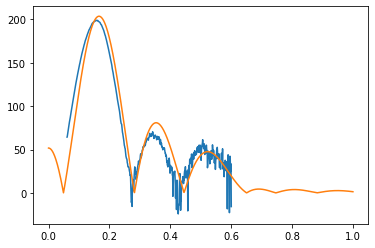

../../Data/Simulations/63a/479/63a47940524010d5a2ff46f0d4c89b4b69e0ad4f/9d9ca60b644e801ec759177e4b1cbe5bf413fe25/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCmacrogFUCHS.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 5120}} MacRog 303.51495825600483 96.16045980964265


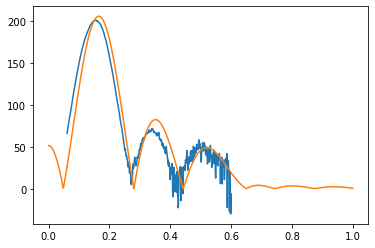

../../Data/Simulations/417/57f/41757fcae2788b4acce2e9b601bfa7c768e8e7b0/fbeaaf46fef02433daa4c430bec6db90de985429/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 184.30217675573203 106.74029114693504


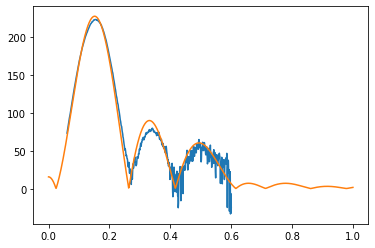

../../Data/Simulations/483/c12/483c128ed18bf2038ea06f46aa4087d174bd7ec5/b974806c63403e6b666cfc8b0fbc2fc71bc1291f/
{'DPPC': {'NAME': 'DPPC', 'MAPPING': 'mappingDPPCslipid.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 3840}} Slipids 174.28931465067996 103.06734634581653


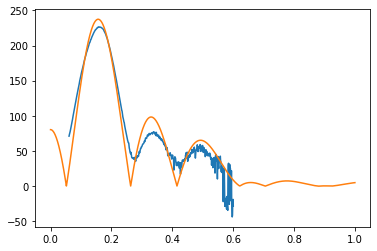

../../Data/Simulations/fbe/d55/fbed55ebb58b32963a3e1c4a94aee9c12304ce9e/af523346e81b780e2e01b1253219c1f03d5dd731/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCcharmm.txt', 'COUNT': [128, 128]}, 'SOL': {'NAME': 'TIP3', 'MAPPING': 'mappingTIP3PCHARMMgui.txt', 'COUNT': 12800}} CHARMM36 705.4751592053381 76.07799092655168


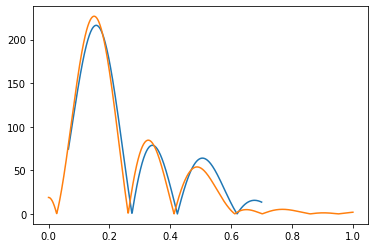

../../Data/Simulations/351/942/3519421ff6c7df40e1da7ac6b6e9ea4d06c911ca/1419f364222a22aadc90d4ec0963e18173e1df2a/
../../Data/Simulations/cc4/a40/cc4a403b0e807a109f793c4acf8d4893f5db01bc/6ec5d72af3c2ccb3d149982aa549b9647c8c7a8e/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 5120}} Slipids 553.2511705301084 103.3061639442578


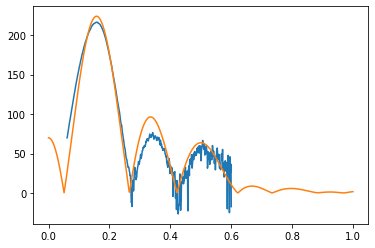

../../Data/Simulations/7e2/66a/7e266a6989c04c46a79a2f444b521c595053c4e1/7de7367161b8ffa3b3388f6b5f61825aacf8a360/
../../Data/Simulations/611/eb1/611eb1451b3406f9a07395e74c89a779da77dd0e/7dacf9299757643c2ab76db9536d80031346829f/
{'POPS': {'NAME': 'POPS', 'MAPPING': 'mappingPOPSlipid17_POPSres.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 3600}, 'SOD': {'NAME': 'NA', 'MAPPING': 'mappingNA.txt', 'COUNT': 72}} Lipid17 and Dang ions 1922.4344543786783 23.096560283149735


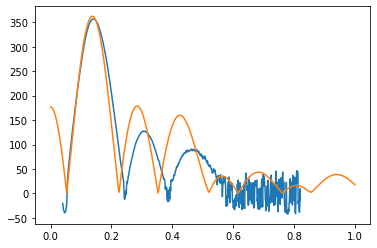

../../Data/Simulations/b06/79c/b0679cd5bb4bed509b91a002305d2771ed4ad54e/72ec31258e95aefa0d053131b9e734b4b11eb030/
../../Data/Simulations/2b1/62c/2b162c80ec2f03952098021beb74ba2cdd3d16c2/d499d1361ef77c3d931995eefdc3d2dbec565ef0/
../../Data/Simulations/007/ed1/007ed172073ee268b07f29ecd413eb9de13a3d47/895cd634e9106b949e0c15cd8873592748b66fed/
{'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 9000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 468.6085627842963 104.8497021978282


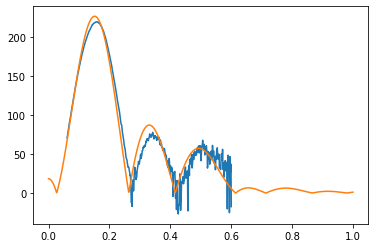

../../Data/Simulations/e8e/789/e8e789ae73225f6e71034f68224d10f599bfbf13/0be719df4c0630bd9df1a8e9d52943ec8f6cd6e7/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [100, 100]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.txt', 'COUNT': 9000}} Slipids 414.92721304551765 97.7899650481512


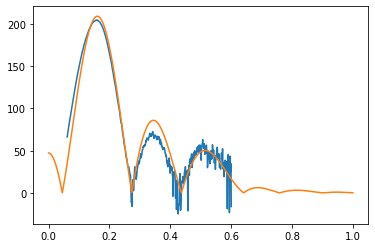

../../Data/Simulations/12a/1ec/12a1ecac877f46809c4377d1e8fb72977396ad94/6149c1c887124543c661efab6619943bf59e7de5/
{'POPS': {'NAME': 'POPS', 'MAPPING': 'mappingPOPSlipid17_POPSres.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 3600}, 'SOD': {'NAME': 'NA', 'MAPPING': 'mappingNA.txt', 'COUNT': 72}} Lipid17 and ff99 ions 669.946453532873 20.36421715245359


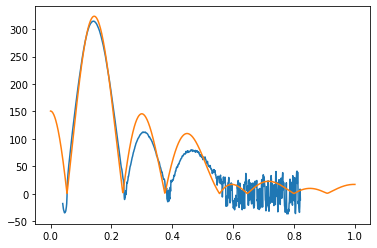

../../Data/Simulations/7a7/591/7a7591afc8a748eb8a19807401ef6d297f36c202/de3454b64be6b9c9d2dc17d873ca1cfbca1c6766/
{'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 9000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} ECC-CHARMM36 737.1913869037024 110.34690651304845


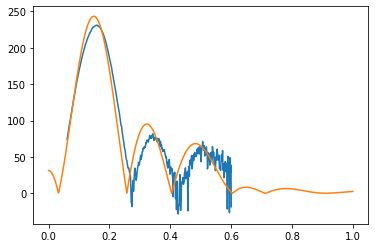

../../Data/Simulations/ce5/80e/ce580ea7b4e991122666ed4fc3c779e3783cbc95/e2c64d1a46b3571951cce2c90ab7302a8f300a9b/
{'POPS': {'NAME': 'POPS', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPSslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4480, 'MAPPING': 'mappingSPCwater.txt'}, 'SOD': {'NAME': 'NA', 'COUNT': 128, 'MAPPING': 'mappingNA.txt'}} Slipids 239.2927911198736 18.66884722526646


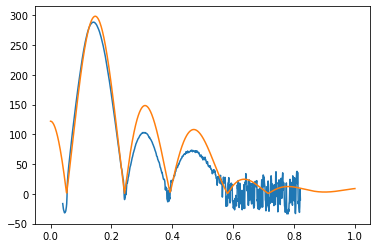

../../Data/Simulations/54b/650/54b6503812c7cd81137b04d302569bcd08aca03b/b56c1f05e72a73558cf1a7ac399a8420648399be/
{'POPC': {'NAME': 'POPC', 'COUNT': [36, 36], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2242, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 1004.1121198899701 87.9056578768622


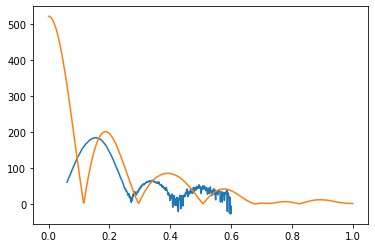

../../Data/Simulations/287/d83/287d83b5b1cc07c2f7dc5f54a8d74227fc6fc3e2/8cad21af3da1756eeb92edb2ab27873891de645d/
../../Data/Simulations/ce4/7a9/ce47a92a012501139c33ff522fb10f436dc57e46/4b88798894afb8a908a8688b5540cb58b0d64bda/
{'POPC': {'NAME': 'POPC', 'COUNT': [900, 900], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 81000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 660.2907183794205 88.97498124724409


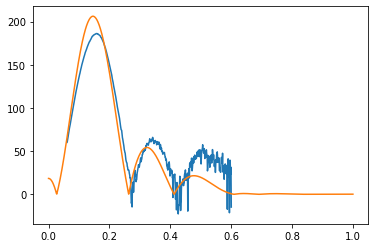

../../Data/Simulations/743/c36/743c36ad0b4bad2cd26b7abd2ff584f49613424e/dcb93acdf33d8c5ac48ade40e4563f0842c3aa9e/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4040, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 213.467130893191 107.12286822064836


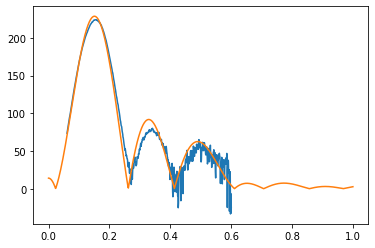

../../Data/Simulations/764/ddd/764dddf7870cc2563bdb74f5b2812b1004ecb63b/bdd86df237be0af314ed4de8ddeb90252d3636af/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 190.6988223382994 106.67811268747457


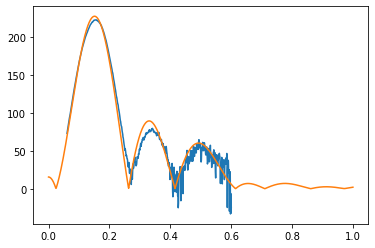

../../Data/Simulations/a63/ca7/a63ca7001cbd5cfc328da122668d1aebc00f2c91/220540156a6ac7813942fd01d998a491b6ff9b8b/
{'POPC': {'NAME': 'POPC', 'COUNT': [128, 128], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 9767, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 204.2420694011491 104.94364713522161


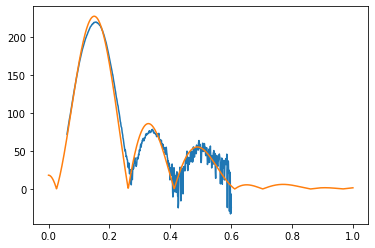

../../Data/Simulations/cf4/038/cf4038c468bcdc08de31d430c456422fe5e7e0bc/6677606cb33c86fe79b9b9ba19e481f2d5388e1c/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 217.54095669943385 107.17467176924958


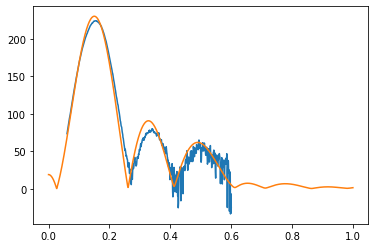

../../Data/Simulations/c85/989/c859898a52a7f5008ecdaa6543f04b293ed846be/1c422966f33deaa912c3b8cc38f39115b4e0e3a4/
{'POPC': {'NAME': 'PC', 'MAPPING': 'mappingPOPClipid14.txt', 'COUNT': [73, 47]}, 'CHOL': {'NAME': 'CHL', 'MAPPING': 'mappingCHOLESTEROLlipid14.txt', 'COUNT': [4, 4]}, 'SOL': {'NAME': 'WAT', 'MAPPING': 'mappingwaterlipid14.txt', 'COUNT': 3968}} Lipid14 1998.6632235783165 54.544548692087524


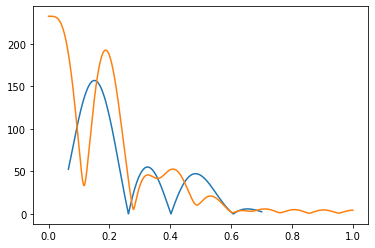

../../Data/Simulations/995/877/9958771b8fb92ac07be7d4285d09f8df65cc758e/5ad07cc3a737f917dc0e69d6f00b44091322ff68/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPClipid14_POPCres.txt', 'COUNT': [64, 64]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingSPCwater.txt', 'COUNT': 6400}} ECC-lipids 277.795835930943 115.15378589736422


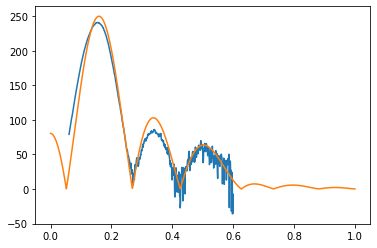

../../Data/Simulations/6c3/ca7/6c3ca7e1ad7705f7acf41f8d4165af31327259f9/77d781e4e8b5f51c484e44cd7b6022f7794bf02d/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPClipid14_POPCres.txt', 'COUNT': [36, 36]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 2234}} Lipid14 504.7206755298986 101.8582293154418


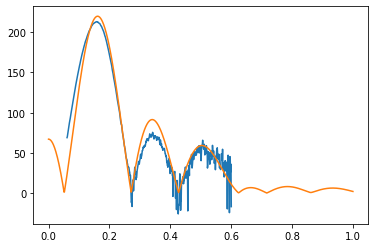

../../Data/Simulations/c8d/54f/c8d54fda73085e3f9685615b4cccc6a3dffc7442/62808d96749eaff3b5572316cb0fbaa4d0863267/
../../Data/Simulations/f58/356/f583561f9fdda76cba873d4a49d39f59818a0767/bde7de03e1e058c7b591ba99895bb94bfbe8a636/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 5120, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} Slipids2020 229.66163474938648 96.17623656601958


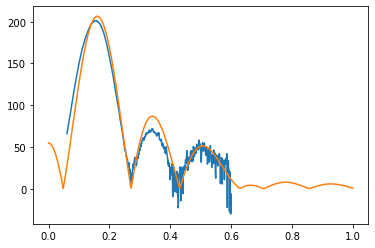

../../Data/Simulations/154/32a/15432a86e2fe83bbb98801da6790567ae983fe58/de431264bc7ef1a732d76af339ef2bbf06bda33c/
../../Data/Simulations/247/965/2479656121ef7f07de1821580d3d9b00c913ca4e/d03acea04b8896f825de65e64bdc9a24b8dd577e/
{'POPC': {'NAME': 'POPC', 'COUNT': [256, 256], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 20480, 'MAPPING': 'mappingSPCwater.txt'}} CHARMM36 472.0556882699853 99.97172022505022


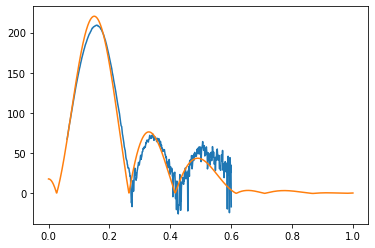

../../Data/Simulations/752/7ec/7527ecdcca76b1db5593639e4e84069b65570f68/5fe5e17ca65737161140a6149290095af1f7056f/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCgaff.txt', 'COUNT': [63, 63]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 3948}} GAFFlipid 225.57296455685466 94.88698628620327


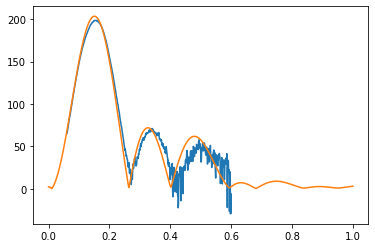

../../Data/Simulations/6e8/031/6e803117ac69d06705e1f024f63ae7e324a0677b/788e5d78db0bd8aafdf3f1d1c0acc33cd7ad0a71/
{'CHOL': {'NAME': 'CHL1', 'COUNT': [12, 12], 'MAPPING': 'mappingCHOLESTEROLcharmm.txt'}, 'POPC': {'NAME': 'POPC', 'COUNT': [50, 50], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4960, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 1430.5776466304123 76.95721731300502


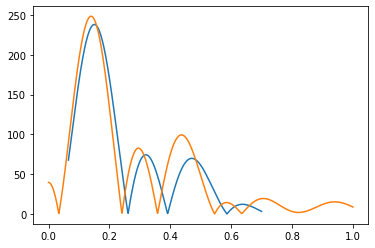

../../Data/Simulations/edf/8a8/edf8a82ed02a87f84c14b740c90dfa718d3f7f8b/1048c4444299bb5adb360e7e17df2b616ab7a4fc/
{'POPC': {'NAME': 'POPC', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 5120, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 243.9942195027229 107.16279524292553


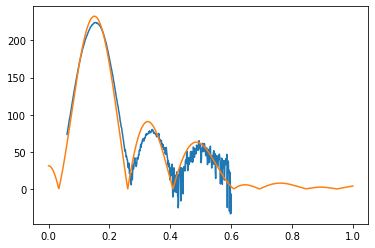

../../Data/Simulations/c4c/487/c4c4872c6b390f70261dbe916557397e7ac04796/2f2177c61a960beea2dbde7afe74d344c2c16f58/
{'POPC': {'NAME': 'POPC', 'COUNT': [36, 36], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 2880, 'MAPPING': 'mappingTIP3Pwater.txt'}} CHARMM36 540.8193494758277 108.11704011678471


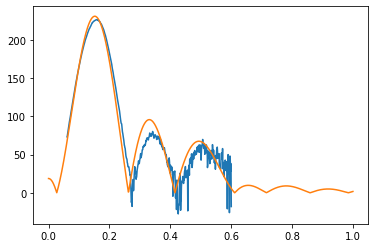

../../Data/Simulations/5a4/277/5a427728e5bcc18a6f162a8d325df4a9e4115250/f0fe9b9284aa683f9a419d9173d320cfa31d34cb/
{'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.txt', 'COUNT': [256, 256]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3Pwater.txt', 'COUNT': 23943}} Slipids 514.7669453777302 70.73741996198142


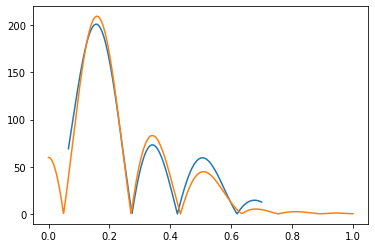

../../Data/Simulations/71a/122/71a122c0825c0aa8efa4b2ab6dbd0b3ceb6f4abe/7a4a14b92fc5cc472f87982f94dc715d2de7ab75/
{'POPC': {'NAME': 'POPC', 'COUNT': [100, 100], 'MAPPING': 'mappingPOPCcharmm.txt'}, 'SOL': {'NAME': 'TIP3', 'COUNT': 9000, 'MAPPING': 'mappingTIP3PCHARMMgui.txt'}} CHARMM36 463.312614565655 104.20406494505704


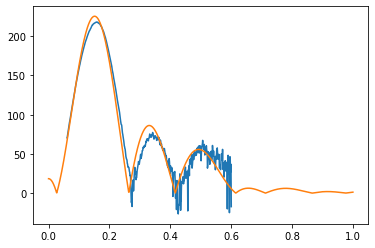

In [8]:
def plotFormFactor(expFormFactor,k):
    xValues = []
    yValues = []
    for i in expFormFactor:
        xValues.append(i[0])
        yValues.append(k*i[1])
    plt.plot(xValues,yValues)

expFFs = '../../Data/experiments/FormFactors/'

for system in systems:
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    
    #print(readme)
    
    if readme['EXPERIMENT']['FORMFACTOR']:
        expFFpath = expFFs + readme['EXPERIMENT']['FORMFACTOR'] +'/'    
        FFQualityFilePath = path + '/FormFactorQuality.json'
    
        with open(FFQualityFilePath) as json_file:
            FFq = json.load(json_file)
        json_file.close()
    
        
        for  subdir, dirs, files in os.walk(expFFpath):
            for filename in files:
                #print(filename)
                filepath = os.path.join(expFFpath, filename)
                #print(filepath)
                if '.json' in filename:
                    with open(filepath) as json_file:
                        expFormFactor = json.load(json_file)
                    print(path)
                    if len(FFq) > 0:
                        print(readme['COMPOSITION'], readme['FF'], FFq[0], FFq[1])
                        plotFormFactor(expFormFactor,FFq[1])
                    #plt.plot(expFormFactor)
        #print(readme['EXPERIMENT']['FORMFACTOR'])
    else:
        continue
    
    FFpath = path + '/FormFactor.json'
    try:
        with open(FFpath) as json_file:
            FormFactor = json.load(json_file)
        json_file.close()
    except:
        continue

    plotFormFactor(FormFactor,1)
    #plt.plot(FormFactor)
    
    plt.show()
    

In [43]:
totalOPquality = []
ffQuality = []
chainQuality = []
for i in qualities:
    try:
        TQ = i['TotalQuality']['total']
        ffQ = i['TotalQuality']['FFQuality']
        chainQ = (i['TotalQuality']['sn-1'] + i['TotalQuality']['sn-2'])/2
        #print(np.average(i['TotalQuality']['sn-1'],i['TotalQuality']['sn-2']))
    except:
        continue
    
    if TQ and ffQ and chainQ:
        totalOPquality.append(TQ)
        ffQuality.append(i['TotalQuality']['FFQuality'])
        chainQuality.append(chainQ)
        if chainQ < 0.3 and ffQ < 500:
            print(i['system'])
            print('')

{'AUTHORS_CONTACT': 'Thomas Piggot', 'FF_DATE': 'pre-2020', 'SYSTEM': '128POPS_4880SOL_128SOD_298K_v2', 'TYPEOFSYSTEM': 'lipid bilayer', 'TEMPERATURE': 298.0, 'PUBLICATION': None, 'NUMBER_OF_ATOMS': 29824, 'EXPERIMENT': {'ORDERPARAMETER': {'POPS': {'10.1021/acs.jctc.9b00824': '10.1021/acs.jctc.9b00824/1', '10.1021/acs.jpcb.9b06091': '10.1021/acs.jpcb.9b06091/1'}}, 'FORMFACTOR': '10.1039/C4SM00066H/1'}, 'FF_SOURCE': 'starting structure from CHARMM-GUI', 'COMPOSITION': {'POPS': {'NAME': 'POPS', 'COUNT': [64, 64], 'MAPPING': 'mappingPOPSslipids.txt'}, 'SOL': {'NAME': 'SOL', 'COUNT': 4480, 'MAPPING': 'mappingSPCwater.txt'}, 'SOD': {'NAME': 'NA', 'COUNT': 128, 'MAPPING': 'mappingNA.txt'}}, 'TIMELEFTOUT': 0, 'CPT': None, 'TRJLENGTH': 100050.0, 'TRAJECTORY_SIZE': 221910896, 'SOFTWARE_VERSION': None, 'FF': 'Slipids', 'TOP': None, 'PREEQTIME': 400, 'DOI': '10.5281/zenodo.1129441', 'DATEOFRUNNING': '12/10/2021', 'TPR': [['for-md-Slipids_10A_cut-off_LJ-PME_POPS_298K_v2.tpr']], 'TRJ': [['md-Slipid

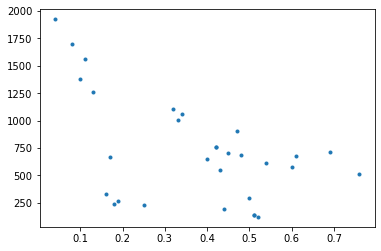

In [40]:
plt.plot(totalOPquality,ffQuality,".")

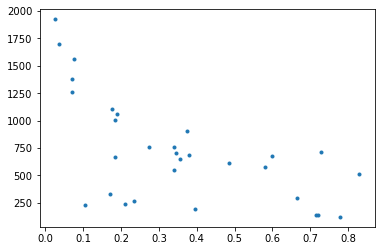

In [41]:
plt.plot(chainQuality,ffQuality,".")